# Mtb-151 PGQC Analysis & Exploration

### Max Marin (mgmarin@g.harvard.edu) 
### Date: 23/12/04


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline


In [3]:
import matplotlib.patches as mpatches


In [4]:
%reload_ext autoreload
%autoreload 2

### import pgqc (pan-genome quality control) toolkit functions
# from pgqc.ava import ava
# from pgqc.nscluster import clusterBy_KmerJC, summarize_NSClusters, create_MaxKmerSim_JC_Dict, create_MST_FiltByJC, make_ClusterID_Maps 
# from pgqc.nscluster import make_NS_ClusterMerged_Pres_DF
# from pgqc.nscluster import summarize_NSClusters_Simple

# from pgqc.utils import parse_PresAbs_Rtab, parse_PresAbs_CSV_Roary, parse_PresAbs_CSV_Panaroo, get_PG_Stats_FromPresAbs

# from pgqc.utils import  parse_PG_Ref_FA, get_PG_Stats_FromDNASeqPresAbs

# from pgqc.utils import get_columns_excluding, PresAbs_InferSampleColOnly

# from pgqc.asm_gene_search import parse_AlnHits_To_DF
# from pgqc.asm_gene_search import PresAbsQC_CheckAsmForGeneSeq, SRAsm_PresAbsQC_CheckInLRAsm
# from pgqc.asm_gene_search import get_SRAsm_Vs_LRAsm_QCStats, get_AsmSeqCheck_QCStats


### import panqc (pan-genome quality control) toolkit functions
from panqc.ava import ava
from panqc.nscluster import clusterBy_KmerJC, summarize_NSClusters, create_MaxKmerSim_JC_Dict, create_MST_FiltByJC, make_ClusterID_Maps 
from panqc.nscluster import make_NS_ClusterMerged_Pres_DF
from panqc.nscluster import summarize_NSClusters_Simple

from panqc.utils import parse_PresAbs_Rtab, parse_PresAbs_CSV_Roary, parse_PresAbs_CSV_Panaroo, get_PG_Stats_FromPresAbs

from panqc.utils import  parse_PG_Ref_FA, get_PG_Stats_FromDNASeqPresAbs

from panqc.utils import get_columns_excluding, PresAbs_InferSampleColOnly

from panqc.asm_gene_search import parse_AlnHits_To_DF
from panqc.asm_gene_search import PresAbsQC_CheckAsmForGeneSeq, SRAsm_PresAbsQC_CheckInLRAsm
from panqc.asm_gene_search import get_SRAsm_Vs_LRAsm_QCStats, get_AsmSeqCheck_QCStats, get_AsmSeqCheck_QCStatsDF




In [5]:
import networkx as nx


In [6]:
def plot_subgraph_with_edge_labels_adjusted(graph, component_nodes):
    # Extract the subgraph
    subgraph = graph.subgraph(component_nodes)
    
    # Position nodes using the spring layout with adjusted spacing
    pos = nx.spring_layout(subgraph, k=0.5)  # Adjust k for closer node spacing
    
    # Draw the subgraph
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10)
    
    # Create edge labels rounded to the nearest hundredth
    edge_labels = nx.get_edge_attributes(subgraph, 'weight')
    edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
    
    # Draw edge labels
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=9)
    
    # Automatically adjust subplot parameters and give some padding
    plt.tight_layout()

    # Optionally, you can manually adjust the axes limits if needed
    # plt.xlim([xmin, xmax])
    # plt.ylim([ymin, ymax])

    # Display the plot
    plt.show()

In [7]:
plt.style.use('./nqo.mplstyle')

In [8]:
#import pgqc

In [9]:
import time

In [10]:
import screed

In [11]:
import mappy as mp

In [12]:
# Set max column width to a specific value (e.g., 100 characters)
pd.set_option('display.max_colwidth', 100)
# Set to display a specific number of columns (e.g., 20 columns)
pd.set_option('display.max_columns', 180)

In [13]:
def PresAbs_GetSampleColOnly(i_Gene_PresAbs_DF):
    PresAbs_NonSampleID_ColNames = ['Gene', 'NumAsm_WiGene', 'NumAsm_WiGene_DNASeq',
                                'Non-unique Gene name', 'Annotation', 'No. isolates',
                                'No. sequences', 'Avg sequences per isolate', 'Genome Fragment',
                                'Order within Fragment', 'Accessory Fragment', 'Accessory Order with Fragment', 'QC',
                                'Min group size nuc', 'Max group size nuc', 'Avg group size nuc']


    ListOf_SampleID_Cols = get_columns_excluding(i_Gene_PresAbs_DF, PresAbs_NonSampleID_ColNames)
    #print(ListOf_SampleID_Cols)
    ColsToRemove = [col for col in i_Gene_PresAbs_DF.columns if col in PresAbs_NonSampleID_ColNames]

    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.drop(ColsToRemove, axis=1)

    return i_Gene_PresAbs_DF, ListOf_SampleID_Cols



# Parse sample metadata & preprocessed genome info/results

In [14]:
!pwd

/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-VCI-MGM/JupyterNotebooks/240103_2_MtbPangenome_151CI_V5


In [15]:
#!ls -1 ../../Data

## Parse sample Metadata (N = 151)

In [16]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

## PARSE PATHs FOR ALL assemblies processed by this pipeline

In [17]:
WGA151CI_LRandSR_Asm_Path_DF = pd.read_csv(MtbSetV3_151CI_InputAsmPATHs_TSV, sep = "\t")

WGA151CI_LRandSR_Asm_Path_DF.columns = ['SampleID', 'Dataset_Tag',
                                        'Genome_LR_ASM_PATH', 'Genome_SR_ASM_PATH']


In [18]:
WGA151CI_LRandSR_Asm_Path_DF.head(1)

,SampleID,Dataset_Tag,Genome_LR_ASM_PATH,Genome_SR_ASM_PATH
0,N0072,ChinerOms_2019,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/...,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/...


#### Create Dict of Asm FA PATHs

In [19]:

LR_AsmFA_Dict = dict(WGA151CI_LRandSR_Asm_Path_DF[['SampleID', 'Genome_LR_ASM_PATH']].values)
SR_AsmFA_Dict = dict(WGA151CI_LRandSR_Asm_Path_DF[['SampleID', 'Genome_SR_ASM_PATH']].values)


### Define Phylo order of samples:

In [20]:
OrderOfSampleIDs_Phylo = ['N0153', 'N0072', 'mada_2-46', 'mada_1-44', 'mada_107',
                          'mada_1-1', 'mada_1-51', 'mada_1-39', 'mada_1-36',
                          'mada_117', 'mada_122', 'mada_118', 'mada_1-10', 'R27252',
                          'R23887', 'TB3091', '9050-05', '3003-06', '702-06', '696-05',
                          '8651-04', 'TB3396', '4549-04', 'TB1612', 'TB2780', 'TB3368',
                          'TB1236', 'TB2659', '8129-04', 'R30215', 'R25048', 'TB2512',
                          'TB2981', 'TB2995', 'TB3113', '706-05', 'R30078', 'R28012',
                          'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'R36431',
                          'R29816', 'S0070-08', 'N0155', 'N0145', 'R29598', 'R24100',
                          'S0107-01', 'R28581', 'S0256-08', 'S0085-01', 'S0089-01',
                          'mada_1-11', 'M0003941_3', 'mada_115', 'mada_2-42', 'R37765',
                          '18_0621851', 'R22601', 'R27937', 'R18040', 'R18043', 'R27725',
                          'R26791', 'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 'R32929',
                          'R26778', 'R30420', 'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004',
                          'mada_1-30', 'N0054', 'N1274', '01_R1134', 'TB2968', 'mada_1-53',
                          'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_123',
                          'mada_1-12', 'mada_1-15', 'mada_128', 'mada_1-38', 'TB3054',
                          'mada_126', 'mada_120', 'TB4620', 'M0016737_0', 'M0016395_7',
                          'R15311', 'TB2661', 'TB3386', 'TB3162', '02_R1179', 'M0010874_7',
                          'QC-7', 'QC-6', 'QC-1', '01_R1430', 'M0011368_9', '02_R1896',
                          'mada_2-25', 'TB3237', 'mada_103', 'mada_112', 'mada_124',
                          'S0123-01', 'S0262-02', 'TB3251', 'M0017522_5', 'R30396', 'R20896',
                          'mada_1-32', 'S0106-01', 'R21839', 'R21363', 'R21770', 'MT_0080','mada_102',
                          'TB3334', 'M0014888_3', 'mada_151', 'TB3169', 'mada_105', 'QC-8',
                          'QC-10', 'QC-4', 'mada_129', 'mada_139', '02_R1708', '02_R0894',
                          'mada_2-31', 'mada_1-41', 'N1272', 'N1176', 'N1202', 'N0091',
                          'N1177','RW-TB008']

### Parse Asm QC results

In [21]:
Repo_DataDir = "../../Data"

AsmSummary_TSVs_Dir = Repo_DataDir + "/231130_WGA-Mtb_CompleteVsSR_AsmSummary_TSVs"   

WGA151CI_AsmQCSumm_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.tsv"
WGA151CI_AsmQC_Tidy_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.Tidy.tsv"


WGA151CI_Asm_LRvsSR_DF = pd.read_csv(WGA151CI_AsmQCSumm_TSV, sep="\t")
print(WGA151CI_Asm_LRvsSR_DF.shape)

WGA151CI_Asm_LRvsSR_TidyDF = pd.read_csv(WGA151CI_AsmQC_Tidy_TSV, sep="\t")
print(WGA151CI_Asm_LRvsSR_TidyDF.shape)

(151, 16)
(302, 11)


In [22]:
SRAsm_BUSCO_Dict = WGA151CI_Asm_LRvsSR_DF.set_index('SampleID')['SRAsm_Busco_Complete_Score'].to_dict()   


### Get SampleIDs associated w/ High & Low BUSCO scores (>= 99 or < 99)

In [23]:
WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99").shape

(136, 16)

In [24]:
WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99").shape

(15, 16)

In [25]:
High_SRBusco_SampleIDs_143CI = WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99")["SampleID"].values     

Low_SRBusco_SampleIDs_15CI = WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99")["SampleID"].values


In [26]:
WGA151CI_AsmSummary_DF.head(5)

,SampleID,numContigs_Complete,Flye_CircContig_Cov,PrimaryLineage,Lineage,Dataset_Tag,AsmApproach
0,N0072,1,358,lineage1,"lineage1,lineage1.1,lineage1.1.2",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
1,N0153,1,372,lineage1,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
2,TB3113,1,933,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon
3,TB1236,1,374,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon
4,TB2659,1,421,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon


#### Make sample lineage & color mapping

In [27]:
# Dictionary for lineage to color mapping
LinToColor_Dict = {
    "lineage1": "#DF83AC",
    "lineage2": "#7098CB",
    "lineage3": "#815D9F",
    "lineage4": "#E76956",
    "lineage5": "#B67548",
    "lineage6": "#6AB79E",
    "lineage8": "#E4515B",
    "None": "black",
}

# Extracting the mapping between IsolateID and PrimaryLineage_Ill
lineage_mapping = WGA151CI_AsmSummary_DF.set_index('SampleID')['PrimaryLineage'].to_dict()

# Creating a color mapping for the samples
sample_colors = {sample: LinToColor_Dict.get(lineage, "black") for sample, lineage in lineage_mapping.items()}


# Define output dir of the Mtb-WGA-SMK processing pipeline

In [28]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"

MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir


## Define output dirs of Pangenome Analysis pipelines

In [29]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"


### Define paths to Pan-genome Analysis output files

In [30]:
# PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
#                          'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
#                          'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
#                          'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default']


PG_OutDir_Dict = { "Panaroo_Strict_MP" : f"{i_Pangenome_Dir}/Panaroo_Strict_MergeParalogs_AllIsolates", 
                     "Panaroo_Moderate_MP" : f"{i_Pangenome_Dir}/Panaroo_Moderate_MergeParalogs_AllIsolates", 
                     "Panaroo_Sens_MP" : f"{i_Pangenome_Dir}/Panaroo_Sensitive_MergeParalogs_AllIsolates",
                     #"Roary_Default" : f"{i_Pangenome_Dir}/Roary_Default_AllIsolates",
                     "Roary_NoSplitParalogs" : f"{i_Pangenome_Dir}/Roary_NoSplitParalogs_AllIsolates", 
                     "Roary_NoSplitParalogs_I90" : f"{i_Pangenome_Dir}/Roary_NoSplitParalogs_I90_AllIsolates",
                     "Roary_NoSplitParalogs_I80" : f"{i_Pangenome_Dir}/Roary_NoSplitParalogs_I80_AllIsolates",
                     "SR_Panaroo_Strict_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Strict_MergeParalogs_AllIsolates",
                     "SR_Panaroo_Moderate_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Moderate_MergeParalogs_AllIsolates",
                     "SR_Panaroo_Sens_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Sensitive_MergeParalogs_AllIsolates",
                     #"SR_Roary_Default": f"{i_Pangenome_Dir}/SR_Roary_Default_AllIsolates",
                     "SR_Roary_NoSplitParalogs": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_AllIsolates",
                     "SR_Roary_NoSplitParalogs_I90": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_I90_AllIsolates",
                     "SR_Roary_NoSplitParalogs_I80": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_I80_AllIsolates"
                   }

PG_PresAbs_CSV_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_CSV_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.csv"  
    
PG_PresAbs_Rtab_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_Rtab_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.Rtab"  

PG_GeneRefFA_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_GeneRefFA_PATH_Dict[i_param] = f"{i_outdir}/pan_genome_reference.fa"  

PG_AvA_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_AvA_PATH_Dict[i_param] = f"{i_outdir}/pan_genome_reference.KmerComparison.AllVsAll.MaxJC.tsv"


PG_PresAbs_AsmGeneSeqChk_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_AsmGeneSeqChk_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.AsmGeneSeqChk.tsv"


# PG_PresAbs_LRAsmQC_PATH_Dict = {}
# for i_param in ["SR_Panaroo_Strict_MP", "SR_Panaroo_MP", "SR_Panaroo_Sens_MP"]:

#     i_outdir = PG_OutDir_Dict[i_param]
#     PG_PresAbs_LRAsmQC_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.csv.DNAseqQCWiLRAsm.csv" 


PG_PresAbs_Rtab_Renamed_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_Rtab_Renamed_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.renamed.Rtab"  


In [31]:
PG_PresAbs_AsmGeneSeqChk_PATH_Dict

{'Panaroo_Strict_MP': '/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Panaroo_Strict_MergeParalogs_AllIsolates/gene_presence_absence.AsmGeneSeqChk.tsv',
 'Panaroo_Moderate_MP': '/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Panaroo_Moderate_MergeParalogs_AllIsolates/gene_presence_absence.AsmGeneSeqChk.tsv',
 'Panaroo_Sens_MP': '/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Panaroo_Sensitive_MergeParalogs_AllIsolates/gene_presence_absence.AsmGeneSeqChk.tsv',
 'Roary_NoSplitParalogs': '/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Roary_NoSplitParalogs_AllIsolates/gene_presence_absence.AsmGeneSeqChk.tsv',
 'Roary_NoSplitParalogs_I90': '/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Roary_NoSplitParalogs_I90_AllIsolates/gene_

In [32]:
Z = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/220720_WGA158CI_V2/PanGenome_Analysis/SR_Roary_Default_AllIsolates/gene_presence_absence.AsmGeneSeqChk.tsv"
!ls -lah $Z



-rw-rw-r-- 1 mm774 farhat 2.0M Oct 17 11:45 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/220720_WGA158CI_V2/PanGenome_Analysis/SR_Roary_Default_AllIsolates/gene_presence_absence.AsmGeneSeqChk.tsv


# Parse in processed data

### A) Parse in processed All vs All Kmer analysis

In [33]:
AvA_DF_Dict = {}

for i_Param, AvA_TSV_PATH in PG_AvA_PATH_Dict.items():

    PG_AvA_DF = pd.read_csv(AvA_TSV_PATH, sep = "\t" )
    AvA_DF_Dict[i_Param] = PG_AvA_DF


### B) Parse in Gene PresAbs Info

In [34]:
PresAbs_DF_Dict = {}

for i_Param, PresAbs_CSV_PATH in PG_PresAbs_CSV_PATH_Dict.items():

    if "Roary" in i_Param: 
        i_Gene_PresAbs_DF = parse_PresAbs_CSV_Roary(PresAbs_CSV_PATH)
    else:
        i_Gene_PresAbs_DF = parse_PresAbs_CSV_Panaroo(PresAbs_CSV_PATH)

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".Bakta")[0] for x in i_Gene_PresAbs_DF.columns ]

    print(i_Param, i_Gene_PresAbs_DF.shape)
    
    PresAbs_DF_Dict[i_Param] = i_Gene_PresAbs_DF
    

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (5,10,12,14,16,24,30,31,32,43,44,48,51,57,59,60,61,62,63,64,68,69,70,71,72,73,74,76,79,82,83,84,86,87,88,89,90,91,93,94,95,96,97,98,99,100,101,102,103,104,105,108,109,110,111,112,113,114,116,117,119,121,122,123,124,126,128,130,132,136,137,140,141,142,144,146,147,148,149,150,151,152,153) have mixed types.Specify dtype option on import or set low_memory=False.
  


Panaroo_Strict_MP (4200, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (12,14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  


Panaroo_Moderate_MP (4280, 153)
Panaroo_Sens_MP (4281, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (32,41,59,60,68,69,70,71,76,79,81,82,83,84,85,90,93,95,99,100,102,103,104,105,108,110,111,116,117,123,128,131,141,143,146,147,149,157,162,164) have mixed types.Specify dtype option on import or set low_memory=False.
  


Roary_NoSplitParalogs (4366, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (16,18,31,32,35,37,41,52,56,59,60,68,69,70,71,73,76,77,79,80,81,82,83,84,85,90,92,93,95,99,100,102,103,104,105,108,110,111,116,117,123,128,131,136,139,141,143,146,147,149,157,162,164) have mixed types.Specify dtype option on import or set low_memory=False.
  


Roary_NoSplitParalogs_I90 (4293, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (16,18,31,32,34,35,37,41,44,45,47,49,52,53,56,59,60,63,64,67,68,69,70,71,73,74,75,76,77,79,80,81,82,83,84,85,86,88,89,90,91,92,93,95,99,100,102,103,104,105,108,110,111,116,117,123,128,131,135,136,137,138,139,140,141,143,145,146,147,149,157,161,162,164) have mixed types.Specify dtype option on import or set low_memory=False.
  


Roary_NoSplitParalogs_I80 (4252, 153)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (7,13,18,26,29,39,89,110,111,125,134,151) have mixed types.Specify dtype option on import or set low_memory=False.
  


SR_Panaroo_Strict_MP (4211, 153)
SR_Panaroo_Moderate_MP (4382, 153)
SR_Panaroo_Sens_MP (4600, 153)
SR_Roary_NoSplitParalogs (5025, 153)
SR_Roary_NoSplitParalogs_I90 (4956, 153)
SR_Roary_NoSplitParalogs_I80 (4866, 153)


### C) Parse in PG Gene Reference FASTAs for each PG output

In [35]:

PG_RefSeqs_DF_Dict = {}

for i_Param, i_PG_Ref_FA_PATH in PG_GeneRefFA_PATH_Dict.items():
    #print(i_PG_Ref_FA_PATH)
    PG_RefSeqs_DF_Dict[i_Param] = parse_PG_Ref_FA(i_PG_Ref_FA_PATH)

    LR_PG_Ref_IDs = list( PG_RefSeqs_DF_Dict[i_Param].keys())
    print(i_Param, len(LR_PG_Ref_IDs))
    

Panaroo_Strict_MP 4200
Panaroo_Moderate_MP 4280
Panaroo_Sens_MP 4281
Roary_NoSplitParalogs 4366
Roary_NoSplitParalogs_I90 4293
Roary_NoSplitParalogs_I80 4252
SR_Panaroo_Strict_MP 4211
SR_Panaroo_Moderate_MP 4382
SR_Panaroo_Sens_MP 4600
SR_Roary_NoSplitParalogs 5025
SR_Roary_NoSplitParalogs_I90 4956
SR_Roary_NoSplitParalogs_I80 4866


In [36]:
PresAbs_DF_AsmSeqChk_Dict = {}

for i_Param, i_PresAbs_DNACheck_TSV_PATH  in PG_PresAbs_AsmGeneSeqChk_PATH_Dict.items():

    i_PresAbs_DNACheck_DF = pd.read_csv(i_PresAbs_DNACheck_TSV_PATH, sep="\t" ).set_index("Gene", drop=False)
    
    PresAbs_DF_AsmSeqChk_Dict[i_Param] = i_PresAbs_DNACheck_DF

    print(i_Param, i_PresAbs_DNACheck_DF.shape)


Panaroo_Strict_MP (4200, 154)
Panaroo_Moderate_MP (4280, 154)
Panaroo_Sens_MP (4281, 154)
Roary_NoSplitParalogs (4366, 154)
Roary_NoSplitParalogs_I90 (4293, 154)
Roary_NoSplitParalogs_I80 (4252, 154)
SR_Panaroo_Strict_MP (4211, 154)
SR_Panaroo_Moderate_MP (4382, 154)
SR_Panaroo_Sens_MP (4600, 154)
SR_Roary_NoSplitParalogs (5025, 154)
SR_Roary_NoSplitParalogs_I90 (4956, 154)
SR_Roary_NoSplitParalogs_I80 (4866, 154)


## D) PresAbs w/ AsmSeqCheck (For both LR and SR Asms)

In [37]:
PresAbs_DF_AsmSeqChk_Dict = {}


for i_Param, PresAbs_AsmSeqChk_CSV_PATH in PG_PresAbs_AsmGeneSeqChk_PATH_Dict.items():

    i_PresAbs_AsmSeqChk_DF = pd.read_csv(PresAbs_AsmSeqChk_CSV_PATH, sep="\t").set_index("Gene", drop=False)  
    
    PresAbs_DF_AsmSeqChk_Dict[i_Param] = i_PresAbs_AsmSeqChk_DF

    print(i_Param, "-", i_PresAbs_AsmSeqChk_DF.shape)



Panaroo_Strict_MP - (4200, 154)
Panaroo_Moderate_MP - (4280, 154)
Panaroo_Sens_MP - (4281, 154)
Roary_NoSplitParalogs - (4366, 154)
Roary_NoSplitParalogs_I90 - (4293, 154)
Roary_NoSplitParalogs_I80 - (4252, 154)
SR_Panaroo_Strict_MP - (4211, 154)
SR_Panaroo_Moderate_MP - (4382, 154)
SR_Panaroo_Sens_MP - (4600, 154)
SR_Roary_NoSplitParalogs - (5025, 154)
SR_Roary_NoSplitParalogs_I90 - (4956, 154)
SR_Roary_NoSplitParalogs_I80 - (4866, 154)


In [38]:
PresAbs_DF_AsmSeqChk_Dict.keys() 

dict_keys(['Panaroo_Strict_MP', 'Panaroo_Moderate_MP', 'Panaroo_Sens_MP', 'Roary_NoSplitParalogs', 'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs_I80', 'SR_Panaroo_Strict_MP', 'SR_Panaroo_Moderate_MP', 'SR_Panaroo_Sens_MP', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90', 'SR_Roary_NoSplitParalogs_I80'])

### AsmSeqCheck Notes
- 0 means absent (CDS AA seq & DNA seq not found in ASM)
- 1 means CDS AA seq present in SR
- 2 Means abesnt but DNA Seq In Asm ("CDS Annotation Discrepancy")


In [39]:
I_PA_ASC_DF = PresAbs_DF_AsmSeqChk_Dict["Panaroo_Moderate_MP"]

AsmSeqCheck_Stats = get_AsmSeqCheck_QCStats(I_PA_ASC_DF, print_stats=False)

In [40]:
AsmSeqCheck_Stats

(23635, 609793, 12852, 36487)

In [41]:
ASC_Stats_DF = pd.DataFrame([AsmSeqCheck_Stats])
ASC_Stats_DF.columns = ["N_Absent_Total", "N_Present", "N_Absent_PresentInDNA", "N_Absent_AbsentInDNA"]


In [42]:
ASC_Stats_DF

,N_Absent_Total,N_Present,N_Absent_PresentInDNA,N_Absent_AbsentInDNA
0,23635,609793,12852,36487


In [43]:
get_AsmSeqCheck_QCStatsDF(I_PA_ASC_DF)

,N_Absent_Total,N_Present,N_Absent_AbsentInDNA,N_Absent_PresentInDNA
0,36487,609793,23635,12852


In [44]:
#PresAbs_DF_AsmSeqChk_Dict

In [45]:
i_PresAbs_AsmSeqChk_DF.head(2)

,Gene,01_R1134,01_R1430,02_R0894,02_R1179,02_R1708,02_R1896,18_0621851,3003-06,4549-04,696-05,702-06,706-05,8129-04,8651-04,9050-05,M0003941_3,M0010874_7,M0011368_9,M0014888_3,M0016395_7,M0016737_0,M0017522_5,MT_0080,N0004,N0054,N0072,N0091,N0145,N0153,N0155,N1176,N1177,N1202,N1272,N1274,QC-1,QC-10,QC-3,QC-4,QC-5,QC-6,QC-7,QC-8,QC-9,R15311,R18040,R18043,R20260,R20574,R20896,R21363,R21408,R21770,R21839,R21893,R22601,R23146,R23571,R23887,R24100,R24120,R25048,R26778,R26791,R27252,R27657,R27725,R27937,R28012,R28581,R28703,R28980,R29598,R29816,R30078,R30215,R30234,R30396,R30420,R31095,R32929,R36431,R37765,RW-TB008,S0070-08,S0085-01,S0089-01,S0106-01,S0107-01,S0123-01,S0256-08,S0262-02,TB1236,TB1612,TB2512,TB2659,TB2661,TB2780,TB2968,TB2981,TB2995,TB3054,TB3091,TB3113,TB3162,TB3169,TB3237,TB3251,TB3334,TB3368,TB3386,TB3396,TB4620,mada_1-1,mada_1-10,mada_1-11,mada_1-12,mada_1-15,mada_1-30,mada_1-32,mada_1-36,mada_1-38,mada_1-39,mada_1-41,mada_1-44,mada_1-50,mada_1-51,mada_1-53,mada_102,mada_103,mada_105,mada_107,mada_112,mada_115,mada_117,mada_118,mada_120,mada_122,mada_123,mada_124,mada_126,mada_128,mada_129,mada_139,mada_151,mada_2-1,mada_2-25,mada_2-31,mada_2-42,mada_2-46,mada_2-53,NumAsm_WiGene,NumAsm_WiGene_DNASeq
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
group_100,group_100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151
mce2R,mce2R,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151


## E) PresAbs w/ SR-PG QC using the LR-Asm

In [46]:
# PresAbs_DF_LRAsmSeqChk_Dict = {}

# for i_Param, PresAbs_LRAsmQC_CSV_PATH in PG_PresAbs_LRAsmQC_PATH_Dict.items():

#     i_PresAbs_LRAsmQC_DF = pd.read_csv(PresAbs_LRAsmQC_CSV_PATH, sep="\t").set_index("Gene", drop=False)  
    
#     PresAbs_DF_LRAsmSeqChk_Dict[i_Param] = i_PresAbs_LRAsmQC_DF

#     print(i_Param, "-", i_PresAbs_LRAsmQC_DF.shape)
#     #!wc -l $PresAbs_LRAsmQC_CSV_PATH

### LRAsmQC of SR Analysis Notes
- 0 means CDS AA seq & DNA seq not found in SR
- 1 means CDS AA seq present in SR
- 3 Means DNA Seq "Not in SR, but In LR Asm", ("Incomplete Assembly")
- 4 Means DNA Seq "In SR Asm, NOT In LR Asm" 
- 5 Means DNA Seq "In SR Asm, In LR Asm" ("Annotation Discrepancy")


In [47]:
#PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param]

In [48]:
PresAbs_DF_Dict[i_Param]

,Gene,01_R1134,01_R1430,02_R0894,02_R1179,02_R1708,02_R1896,18_0621851,3003-06,4549-04,696-05,702-06,706-05,8129-04,8651-04,9050-05,M0003941_3,M0010874_7,M0011368_9,M0014888_3,M0016395_7,M0016737_0,M0017522_5,MT_0080,N0004,N0054,N0072,N0091,N0145,N0153,N0155,N1176,N1177,N1202,N1272,N1274,QC-1,QC-10,QC-3,QC-4,QC-5,QC-6,QC-7,QC-8,QC-9,R15311,R18040,R18043,R20260,R20574,R20896,R21363,R21408,R21770,R21839,R21893,R22601,R23146,R23571,R23887,R24100,R24120,R25048,R26778,R26791,R27252,R27657,R27725,R27937,R28012,R28581,R28703,R28980,R29598,R29816,R30078,R30215,R30234,R30396,R30420,R31095,R32929,R36431,R37765,RW-TB008,S0070-08,S0085-01,S0089-01,S0106-01,S0107-01,S0123-01,S0256-08,S0262-02,TB1236,TB1612,TB2512,TB2659,TB2661,TB2780,TB2968,TB2981,TB2995,TB3054,TB3091,TB3113,TB3162,TB3169,TB3237,TB3251,TB3334,TB3368,TB3386,TB3396,TB4620,mada_1-1,mada_1-10,mada_1-11,mada_1-12,mada_1-15,mada_1-30,mada_1-32,mada_1-36,mada_1-38,mada_1-39,mada_1-41,mada_1-44,mada_1-50,mada_1-51,mada_1-53,mada_102,mada_103,mada_105,mada_107,mada_112,mada_115,mada_117,mada_118,mada_120,mada_122,mada_123,mada_124,mada_126,mada_128,mada_129,mada_139,mada_151,mada_2-1,mada_2-25,mada_2-31,mada_2-42,mada_2-46,mada_2-53,NumAsm_WiGene
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
group_100,group_100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151
mce2R,mce2R,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151
moxR2,moxR2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151
group_4355,group_4355,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151
dacB1,dacB1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
group_2832,group_2832,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
group_2831,group_2831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Part 1: Run the `NS-cluster step` on the output of the `AsmSeqCheck` step of PGQC

## A) Perform NucSim clustering (JC > 0.8) analysis AFTER AsmSeqCheck step

In [49]:
PresAbs_AsmSeqCheck_And_NSC08_Dict = {}

ClusterStats_AsmSeqCheck_And_NSC08_Dict = {}

MSTGraph_Dict = {}

ListOf_SampleID_Cols = SampleIDs_151CI_SOI

N_Genomes = len(SampleIDs_151CI_SOI)

CoreGenome_Thresh = N_Genomes * 0.99

for i_Param, AvA_TSV_PATH in AvA_DF_Dict.items():

    PG_AvA_DF = AvA_DF_Dict[i_Param]

    PresAbs_DNACheck_DF = PresAbs_DF_AsmSeqChk_Dict[i_Param]
    
    Gene_PresAbs_DF = PresAbs_DNACheck_DF.copy() #.drop("NumAsm_WiGene_DNASeq", axis =1)
    
    PresAbs_NSC_Filt08_DF, ClusterInfoGraphDict = clusterBy_KmerJC(PG_AvA_DF, Gene_PresAbs_DF, 0.8)

    Filt08_MST_Graph = ClusterInfoGraphDict["MST_Filt_Graph"]
    
    Filt08_Cluster_DF = ClusterInfoGraphDict["Filt_Cluster_DF"]
    
    print(i_Param, Filt08_Cluster_DF.shape[0])

    CoreGenes_List = Gene_PresAbs_DF.query(f"NumAsm_WiGene >= {CoreGenome_Thresh}")["Gene"].values
    
    Filt08_Cluster_WiType_DF, Filt08_ClusterType_Count = summarize_NSClusters(Filt08_Cluster_DF,
                                                                              CoreGenes_List, False)

    PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param] = PresAbs_NSC_Filt08_DF
    
    ClusterStats_AsmSeqCheck_And_NSC08_Dict[i_Param] = Filt08_Cluster_DF
    
    MSTGraph_Dict[i_Param] = Filt08_MST_Graph

    #print("-"*20 + "\n")
    

Panaroo_Strict_MP 250
Panaroo_Moderate_MP 275
Panaroo_Sens_MP 276
Roary_NoSplitParalogs 347
Roary_NoSplitParalogs_I90 272
Roary_NoSplitParalogs_I80 235
SR_Panaroo_Strict_MP 233
SR_Panaroo_Moderate_MP 351
SR_Panaroo_Sens_MP 582
SR_Roary_NoSplitParalogs 1074
SR_Roary_NoSplitParalogs_I90 1017
SR_Roary_NoSplitParalogs_I80 953


In [50]:
Filt08_Cluster_DF.shape

(953, 5)

In [51]:
Filt08_Cluster_DF["NS_ClusterName"].nunique()

352

In [52]:
Filt08_Cluster_DF.head(4)

,GeneID,NS_ClusterName,NS_ClusterNum,NS_ClusterID,GeneType
0,group_2531,group_2531---zmp1,0,NS_0,Accessory
1,zmp1,group_2531---zmp1,0,NS_0,Accessory
2,uspC,uspC---group_2469,1,NS_1,Core
3,group_2469,uspC---group_2469,1,NS_1,Accessory


In [53]:
i_Param = "Panaroo_Strict_MP"

i_SampleIDs = WGA151CI_SampleIDs

PA_DF = PresAbs_DF_Dict[i_Param]

PA_OG_DF = PresAbs_DF_Dict[i_Param]

PA_DNACheck_DF = PresAbs_DF_AsmSeqChk_Dict[i_Param]

PA_NRA_DF = PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param]

In [54]:
get_PG_Stats_FromPresAbs(PA_OG_DF, 151)

Accessory Thresh: 149.49


(4200, 3779, 421)

In [55]:
get_PG_Stats_FromPresAbs(PA_DNACheck_DF, 151)

Accessory Thresh: 149.49


(4200, 3779, 421)

In [56]:
get_PG_Stats_FromPresAbs(PA_NRA_DF, 151)

Accessory Thresh: 149.49


(4061, 3792, 269)

In [57]:
PA_DNACheck_DF.head(4)

,Gene,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NumAsm_WiGene,NumAsm_WiGene_DNASeq
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
group_2273,group_2273,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151
group_619,group_619,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151
moeX,moeX,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151
eccE3,eccE3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,151


In [58]:
PA_DNACheck_DF.tail(4)

,Gene,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NumAsm_WiGene,NumAsm_WiGene_DNASeq
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
group_1501,group_1501,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,151
group_1557,group_1557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
group_1691,group_1691,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,151
group_10,group_10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [122]:
i_PA_ASC_DF = PA_DNACheck_DF
NAbs_0 = (i_PA_ASC_DF[i_SampleIDs] == 0).sum().sum()
NPres_1 = (i_PA_ASC_DF[i_SampleIDs] == 1).sum().sum()
NPres_InASC_2 = (i_PA_ASC_DF[i_SampleIDs] == 2).sum().sum()  
print(i_Param, NAbs_0, NPres_1, NPres_InASC_2)  


Panaroo_Strict_MP 22262 601154 10784


In [123]:
len(i_SampleIDs)

151

In [124]:
i_AvA_DF = AvA_DF_Dict[i_Param]
i_AvA_DF.shape

(1356, 5)

In [125]:

i_MSTG = MSTGraph_Dict[i_Param]

i_Cluster_DF = ClusterStats_AsmSeqCheck_And_NSC08_Dict[i_Param] 

NumGenesPerNSC = i_Cluster_DF["NS_ClusterID"].value_counts().to_dict()

i_Cluster_DF["N_Genes"] = i_Cluster_DF["NS_ClusterID"].map(NumGenesPerNSC)

i_Cluster_DF["NS_ClusterID"].nunique()

111

In [104]:
i_Cluster_DF.head(5)

,GeneID,NS_ClusterName,NS_ClusterNum,NS_ClusterID,GeneType,N_Genes
0,group_1560,group_1560---plcC,0,NS_0,Accessory,2
1,plcC,group_1560---plcC,0,NS_0,Accessory,2
2,pPE15,pPE15---pE8,1,NS_1,Accessory,2
3,pE8,pPE15---pE8,1,NS_1,Core,2
4,group_809,group_809---group_1011---group_89---cyp128,2,NS_2,Accessory,4


In [136]:
i_Cluster_DF.head(20)

,GeneID,NS_ClusterName,NS_ClusterNum,NS_ClusterID,GeneType,N_Genes
0,group_1560,group_1560---plcC,0,NS_0,Accessory,2
1,plcC,group_1560---plcC,0,NS_0,Accessory,2
2,pPE15,pPE15---pE8,1,NS_1,Accessory,2
3,pE8,pPE15---pE8,1,NS_1,Core,2
4,group_809,group_809---group_1011---group_89---cyp128,2,NS_2,Accessory,4
5,group_1011,group_809---group_1011---group_89---cyp128,2,NS_2,Core,4
6,group_89,group_809---group_1011---group_89---cyp128,2,NS_2,Accessory,4
7,cyp128,group_809---group_1011---group_89---cyp128,2,NS_2,Accessory,4
8,group_666,group_666---group_1418,3,NS_3,Accessory,2
9,group_1418,group_666---group_1418,3,NS_3,Core,2


In [143]:
i_Cluster_DF.tail(20)

,GeneID,NS_ClusterName,NS_ClusterNum,NS_ClusterID,GeneType,N_Genes
230,group_24,group_24---group_1328,102,NS_102,Accessory,2
231,group_1328,group_24---group_1328,102,NS_102,Accessory,2
232,group_2070,group_2070---group_1960,103,NS_103,Core,2
233,group_1960,group_2070---group_1960,103,NS_103,Accessory,2
234,group_893,group_893---group_154,104,NS_104,Core,2
235,group_154,group_893---group_154,104,NS_104,Accessory,2
236,group_1882,group_1882---group_2042,105,NS_105,Accessory,2
237,group_2042,group_1882---group_2042,105,NS_105,Core,2
238,group_279,group_279---group_1384,106,NS_106,Accessory,2
239,group_1384,group_279---group_1384,106,NS_106,Core,2


['group_809' 'group_1011' 'group_89' 'cyp128']


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


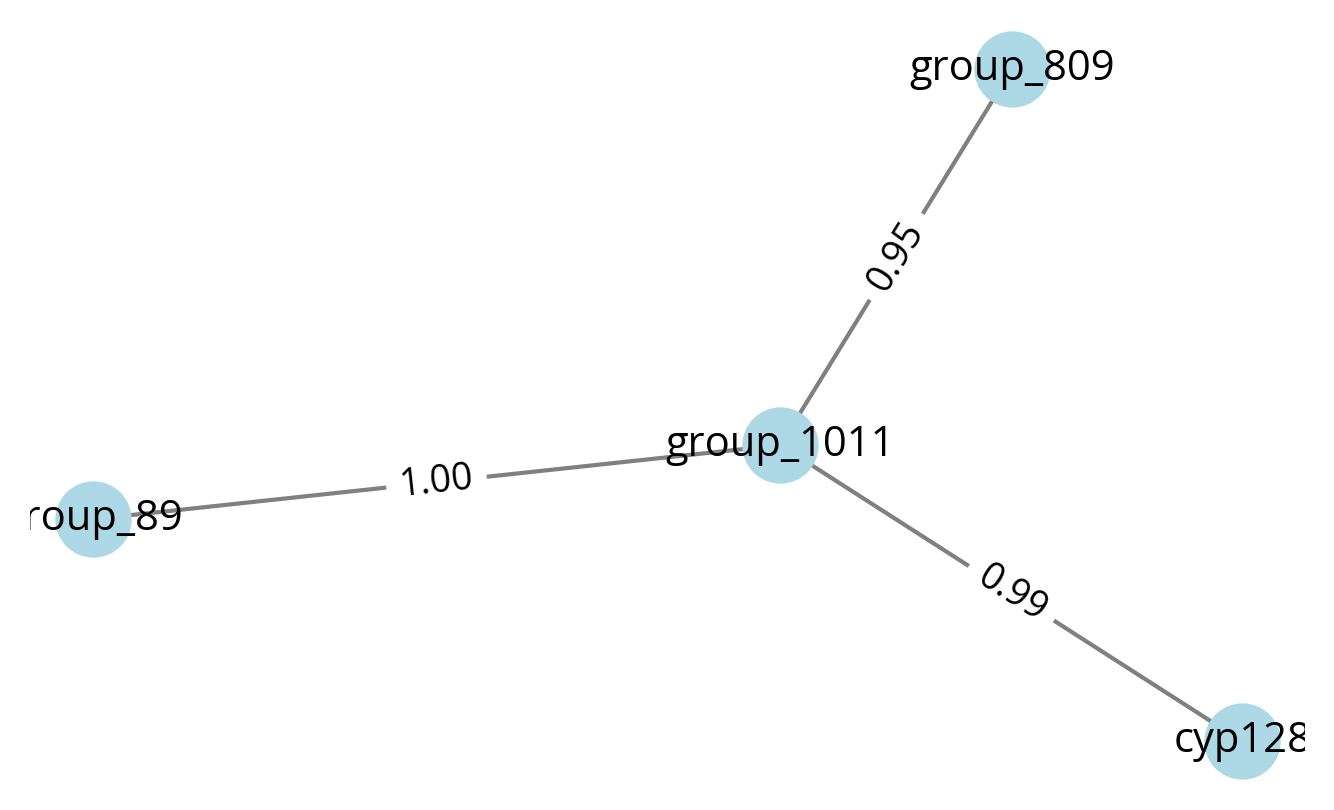

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,MaxJaccardContain
2,group_89,group_1011,249,2634,1.000000
33,group_1011,cyp128,2634,1470,0.990278
76,group_809,group_1011,837,2634,0.952912


In [146]:
i_NS_ID = "NS_2"

NS_GeneIDs = i_Cluster_DF.query(f" NS_ClusterID == '{i_NS_ID}' ")["GeneID"].values
print(NS_GeneIDs)

i_AvA_ForNSC = i_AvA_DF[ i_AvA_DF["RecordID_1"].isin(NS_GeneIDs) | i_AvA_DF["RecordID_2"].isin(NS_GeneIDs) ]
plot_subgraph_with_edge_labels_adjusted(i_MSTG, NS_GeneIDs)

i_AvA_ForNSC.query("MaxJaccardContain > 0.8")

In [147]:
249 + 1470 + 837

2556

['group_963' 'group_2155' 'group_1438' 'group_2154']


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


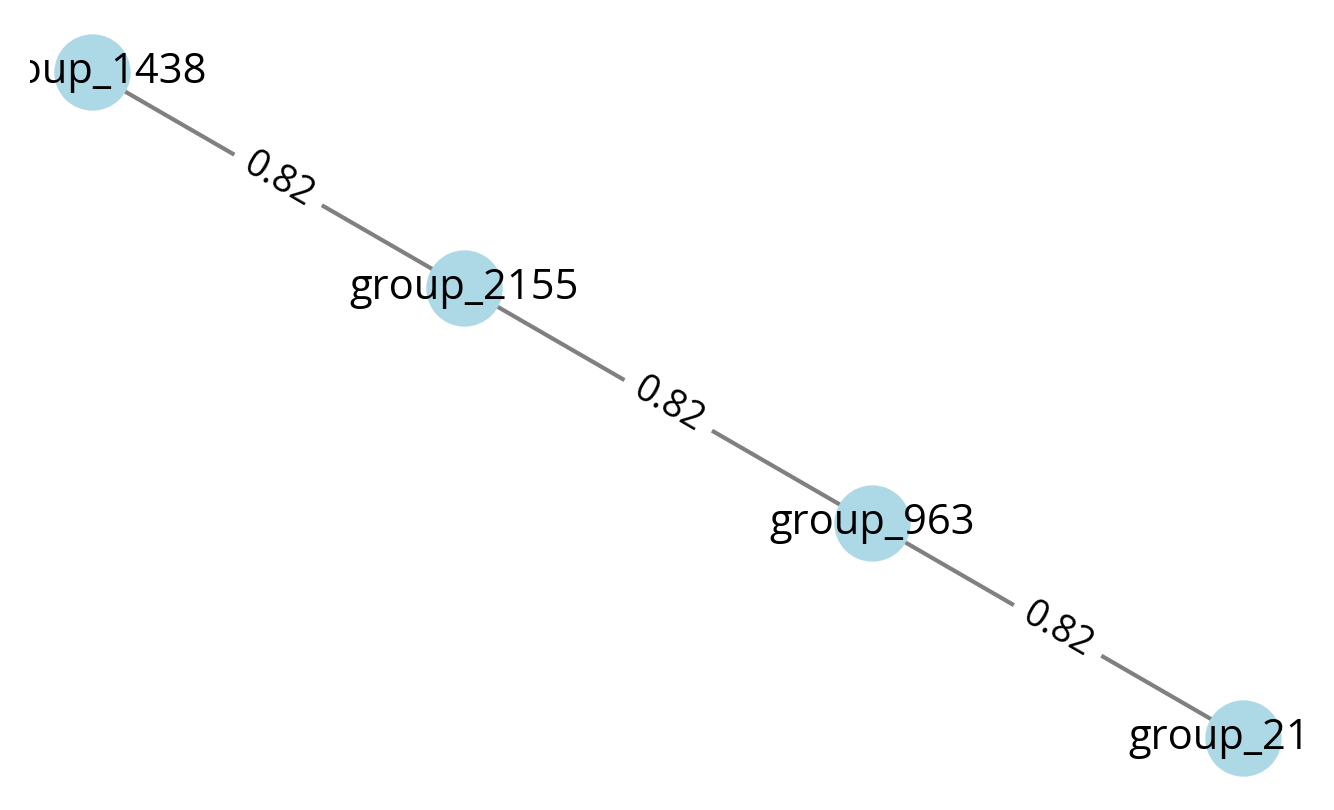

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,MaxJaccardContain
151,group_963,group_2155,178,1386,0.824324
152,group_963,group_2154,178,1392,0.824324
153,group_1438,group_2155,963,1386,0.815648
160,group_1438,group_2154,963,1392,0.786710
219,group_2154,group_2155,1392,1386,0.612832
222,group_963,group_1438,178,963,0.594595
295,group_1994,group_2154,297,1392,0.438202
386,ylaD,group_2155,714,1386,0.304094
589,group_1944,group_2154,366,1392,0.199405


In [149]:
i_NS_ID = "NS_107"

NS_GeneIDs = i_Cluster_DF.query(f" NS_ClusterID == '{i_NS_ID}' ")["GeneID"].values
print(NS_GeneIDs)

i_AvA_ForNSC = i_AvA_DF[ i_AvA_DF["RecordID_1"].isin(NS_GeneIDs) | i_AvA_DF["RecordID_2"].isin(NS_GeneIDs) ]
plot_subgraph_with_edge_labels_adjusted(i_MSTG, NS_GeneIDs)

i_AvA_ForNSC #.query("MaxJaccardContain > 0.8")

['group_2100' 'group_129' 'group_1971' 'group_254' 'pPE24']


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


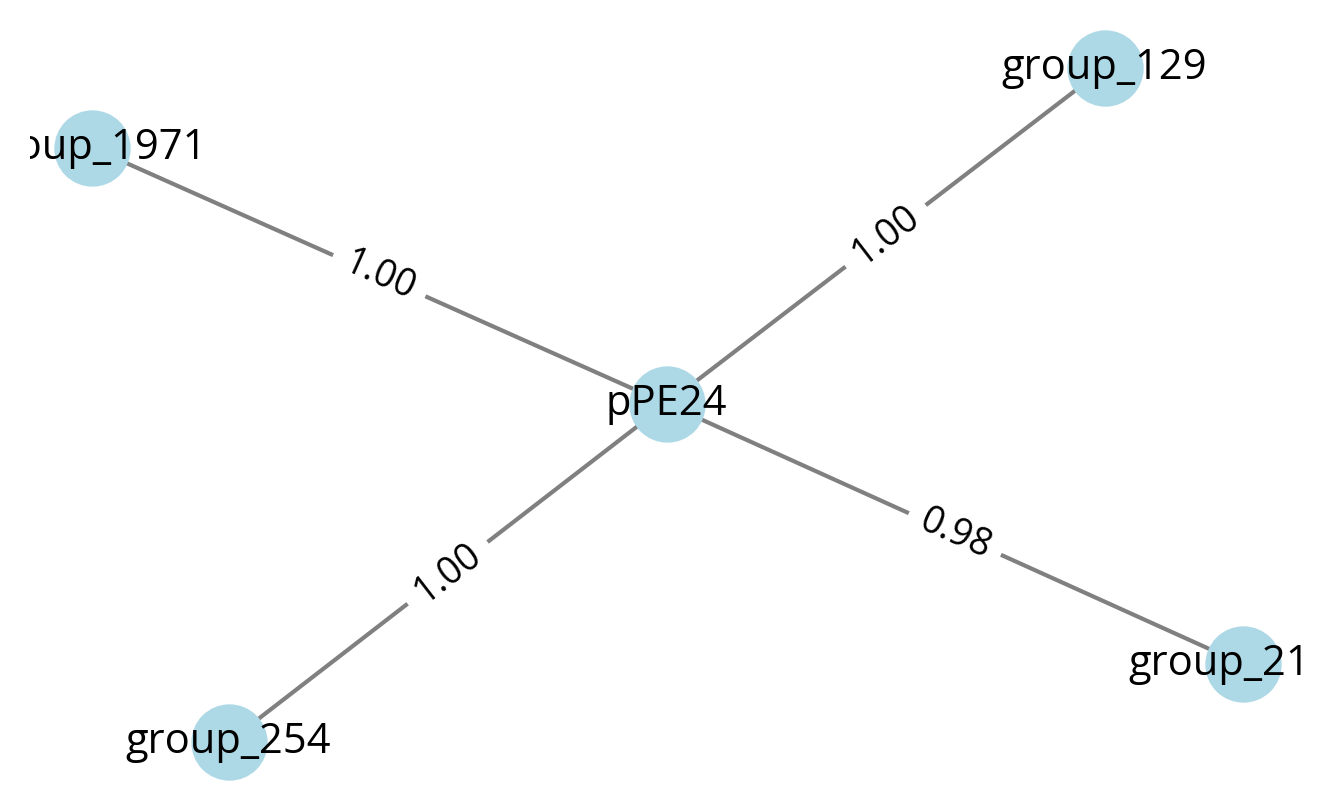

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,MaxJaccardContain
7,group_254,pPE24,153,4233,1.000000
8,group_254,group_2100,153,4011,1.000000
12,group_1971,pPE24,435,4233,1.000000
13,group_1971,group_2100,435,4011,1.000000
18,group_129,pPE24,228,4233,1.000000
19,group_129,group_2100,228,4011,1.000000
49,pPE24,group_2100,4233,4011,0.977419


In [150]:
i_NS_ID = "NS_7"

NS_GeneIDs = i_Cluster_DF.query(f" NS_ClusterID == '{i_NS_ID}' ")["GeneID"].values
print(NS_GeneIDs)

i_AvA_ForNSC = i_AvA_DF[ i_AvA_DF["RecordID_1"].isin(NS_GeneIDs) | i_AvA_DF["RecordID_2"].isin(NS_GeneIDs) ]

plot_subgraph_with_edge_labels_adjusted(i_MSTG, NS_GeneIDs)

i_AvA_ForNSC.query("MaxJaccardContain > 0.8")


In [ ]:
i_AvA_DF.head(5)

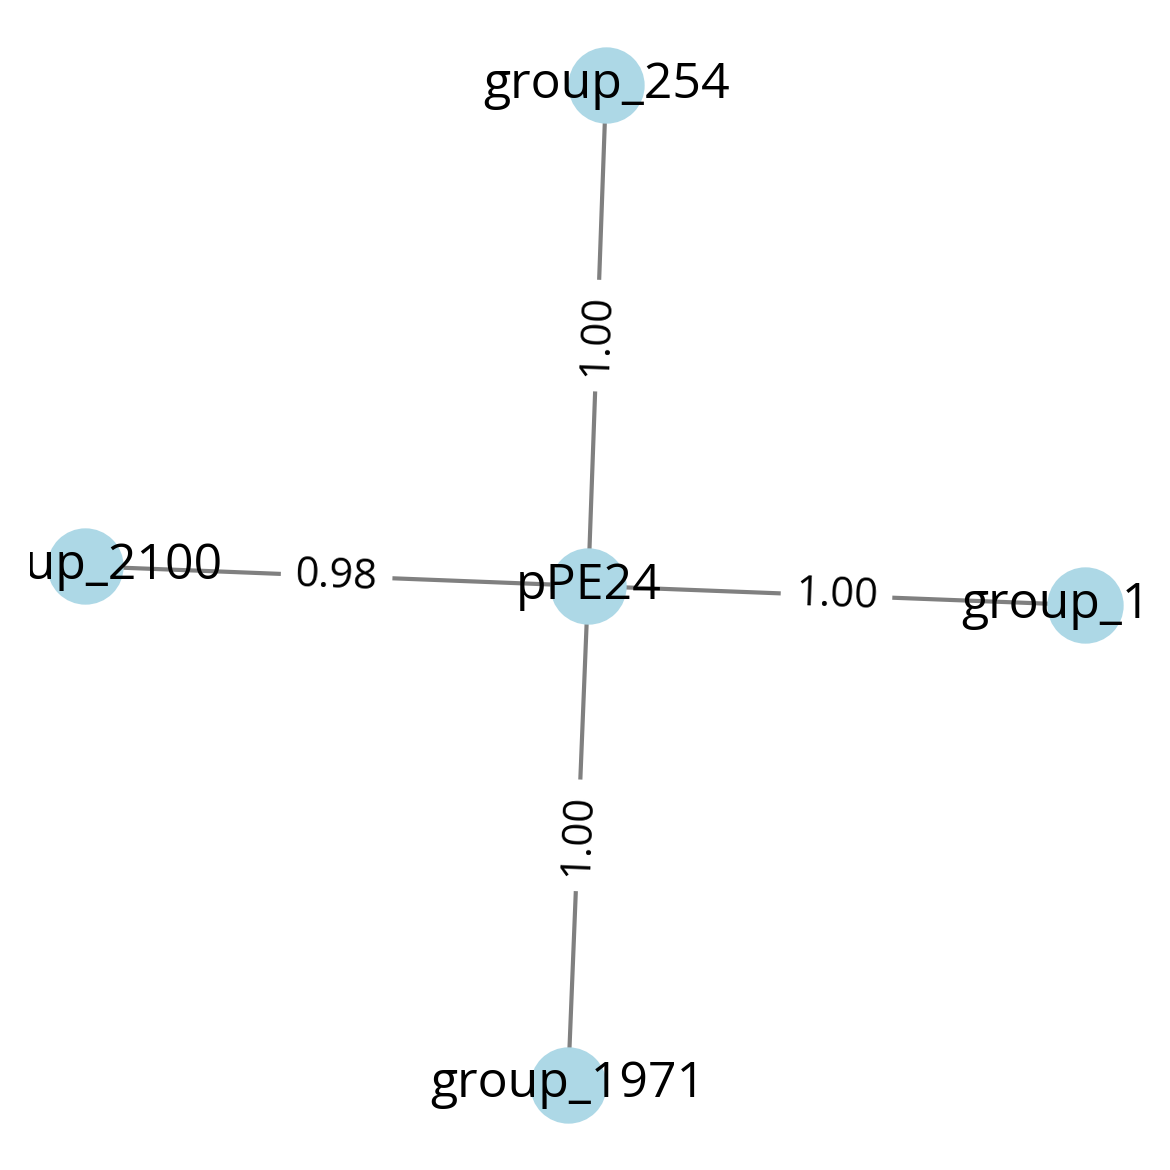

In [162]:
# Assuming 'graph' is your original graph object and 'component_nodes' is a list of node names
# Extract the subgraph
subgraph = i_MSTG.subgraph(NS_GeneIDs)

# Position nodes using a layout of your choice, spring_layout is a good default
pos = nx.spring_layout(subgraph)


fig, axs = plt.subplots(1,1, figsize= (4, 4))

# Draw the subgraph
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# Label edge weights
edge_labels = nx.get_edge_attributes(subgraph, 'weight')  # Assuming 'weight' is the attribute name for edge weights
edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}

nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

# # Now, visualize the subgraph using the same approach as above
# pos = nx.spring_layout(subgraph)
# nx.draw_networkx_nodes(subgraph, pos)
# nx.draw_networkx_edges(subgraph, pos)
# nx.draw_networkx_labels(subgraph, pos)
# plt.show()

['pPE15' 'pE8']


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


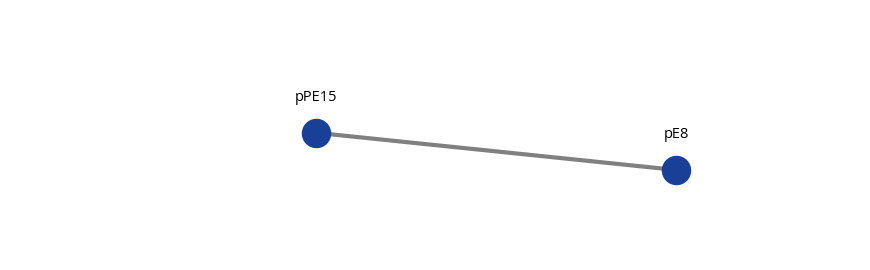

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,MaxJaccardContain
1,pPE15,pE8,1176,2079,1.0


In [221]:
i_NS_ID = "NS_1"

NS_GeneIDs = i_Cluster_DF.query(f" NS_ClusterID == '{i_NS_ID}' ")["GeneID"].values
print(NS_GeneIDs)

i_AvA_ForNSC = i_AvA_DF[ i_AvA_DF["RecordID_1"].isin(NS_GeneIDs) | i_AvA_DF["RecordID_2"].isin(NS_GeneIDs) ]

# Assuming 'graph' is your original graph object and 'component_nodes' is a list of node names
# Extract the subgraph
fig, axs = plt.subplots(1,1, figsize= (3, 1))


subgraph = i_MSTG.subgraph(NS_GeneIDs)
G = subgraph

pos = nx.nx_agraph.graphviz_layout(G, prog='neato', args='-Gscale=.100')

# Label edge weights
edge_labels = nx.get_edge_attributes(subgraph, 'weight')  # Assuming 'weight' is the attribute name for edge weights
#edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}


nx.draw(G,
        pos,
        node_size=50,
        width=1, # list(edge_labels.values()),
        linewidths = 0,
        edge_color='grey',
        node_color='#1a3f96',
        with_labels=False)

label_pos = {k: [v[0], v[1]+ 1] for k, v in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=3.5)

plt.xlim(34, 50)
plt.ylim(16, 22)

plt.show()

i_AvA_ForNSC.query("MaxJaccardContain > 0.8")


In [214]:
pos.items()

dict_items([('pPE15', (39.646, 19.064)), ('pE8', (46.767, 18.0))])

['group_809' 'group_1011' 'group_89' 'cyp128']


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


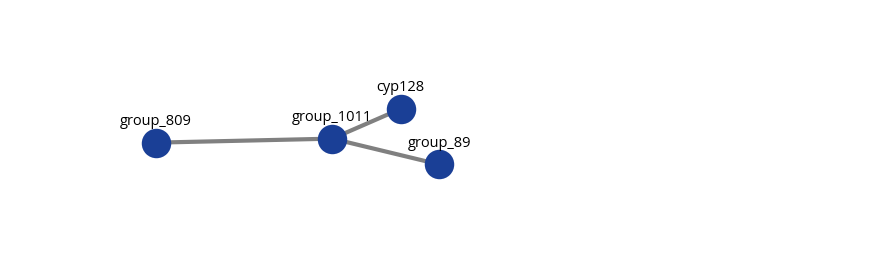

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,MaxJaccardContain
2,group_89,group_1011,249,2634,1.000000
33,group_1011,cyp128,2634,1470,0.990278
76,group_809,group_1011,837,2634,0.952912


In [219]:
i_NS_ID = "NS_2"

NS_GeneIDs = i_Cluster_DF.query(f" NS_ClusterID == '{i_NS_ID}' ")["GeneID"].values
print(NS_GeneIDs)

i_AvA_ForNSC = i_AvA_DF[ i_AvA_DF["RecordID_1"].isin(NS_GeneIDs) | i_AvA_DF["RecordID_2"].isin(NS_GeneIDs) ]

# Assuming 'graph' is your original graph object and 'component_nodes' is a list of node names
# Extract the subgraph
fig, axs = plt.subplots(1,1, figsize= (3, 1))


subgraph = i_MSTG.subgraph(NS_GeneIDs)
G = subgraph
pos = nx.nx_agraph.graphviz_layout(G, prog='neato', args='-Gscale=.100')

# Label edge weights
edge_labels = nx.get_edge_attributes(subgraph, 'weight')  # Assuming 'weight' is the attribute name for edge weights
#edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}


nx.draw(G,
        pos,
        node_size=50,
        width=1, # list(edge_labels.values()),
        linewidths = 0,
        edge_color='grey',
        node_color='#1a3f96',
        with_labels=False)

label_pos = {k: [v[0], v[1]+5] for k, v in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=3.5)

plt.xlim(55, 90)
plt.ylim(0, 50)

plt.show()

i_AvA_ForNSC.query("MaxJaccardContain > 0.8")


['group_2100' 'group_129' 'group_1971' 'group_254' 'pPE24']


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


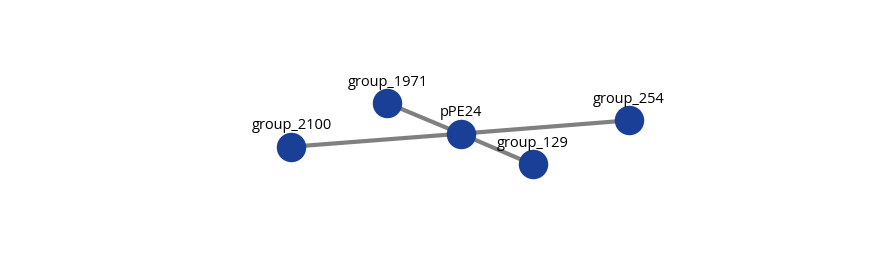

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,MaxJaccardContain
7,group_254,pPE24,153,4233,1.000000
8,group_254,group_2100,153,4011,1.000000
12,group_1971,pPE24,435,4233,1.000000
13,group_1971,group_2100,435,4011,1.000000
18,group_129,pPE24,228,4233,1.000000
19,group_129,group_2100,228,4011,1.000000
49,pPE24,group_2100,4233,4011,0.977419


In [222]:
i_NS_ID = "NS_7"

NS_GeneIDs = i_Cluster_DF.query(f" NS_ClusterID == '{i_NS_ID}' ")["GeneID"].values
print(NS_GeneIDs)

i_AvA_ForNSC = i_AvA_DF[ i_AvA_DF["RecordID_1"].isin(NS_GeneIDs) | i_AvA_DF["RecordID_2"].isin(NS_GeneIDs) ]

# Assuming 'graph' is your original graph object and 'component_nodes' is a list of node names
# Extract the subgraph
fig, axs = plt.subplots(1,1, figsize= (3, 1))


subgraph = i_MSTG.subgraph(NS_GeneIDs)
G = subgraph
pos = nx.nx_agraph.graphviz_layout(G, prog='neato', args='-Gscale=.100')

# Label edge weights
edge_labels = nx.get_edge_attributes(subgraph, 'weight')  # Assuming 'weight' is the attribute name for edge weights
#edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}


nx.draw(G,
        pos,
        node_size=50,
        width=1, # list(edge_labels.values()),
        linewidths = 0,
        edge_color='grey',
        node_color='#1a3f96',
        with_labels=False)

label_pos = {k: [v[0], v[1]+5] for k, v in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=3.5)

plt.xlim(55, 90)
plt.ylim(0, 50)

plt.show()

i_AvA_ForNSC.query("MaxJaccardContain > 0.8")


['group_963' 'group_2155' 'group_1438' 'group_2154']


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


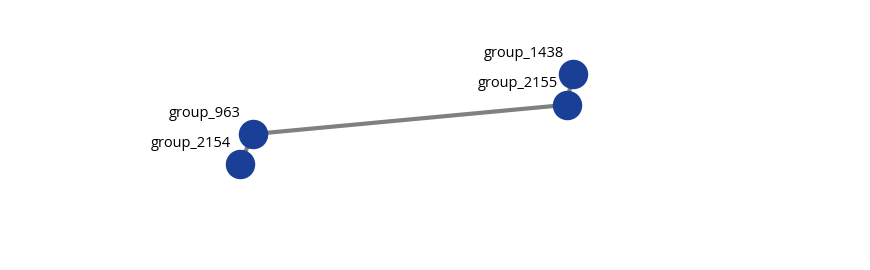

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,MaxJaccardContain
151,group_963,group_2155,178,1386,0.824324
152,group_963,group_2154,178,1392,0.824324
153,group_1438,group_2155,963,1386,0.815648


In [232]:
i_NS_ID = "NS_107"

NS_GeneIDs = i_Cluster_DF.query(f" NS_ClusterID == '{i_NS_ID}' ")["GeneID"].values
print(NS_GeneIDs)

i_AvA_ForNSC = i_AvA_DF[ i_AvA_DF["RecordID_1"].isin(NS_GeneIDs) | i_AvA_DF["RecordID_2"].isin(NS_GeneIDs) ]

# Assuming 'graph' is your original graph object and 'component_nodes' is a list of node names
# Extract the subgraph
fig, axs = plt.subplots(1,1, figsize= (3, 1))


subgraph = i_MSTG.subgraph(NS_GeneIDs)
G = subgraph
pos = nx.nx_agraph.graphviz_layout(G, prog='neato', args='-Gscale=.100')

# Label edge weights
edge_labels = nx.get_edge_attributes(subgraph, 'weight')  # Assuming 'weight' is the attribute name for edge weights
#edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}


nx.draw(G,
        pos,
        node_size=50,
        width=1, # list(edge_labels.values()),
        linewidths = 0,
        edge_color='grey',
        node_color='#1a3f96',
        with_labels=False)

label_pos = {k: [v[0]-0.3, v[1]+5] for k, v in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=3.5)

plt.xlim(65, 70)
plt.ylim(0, 50)

plt.show()

i_AvA_ForNSC.query("MaxJaccardContain > 0.8")


In [176]:
pos.items()

dict_items([('group_2100', (66.294, 22.208)), ('group_129', (76.717, 18.0)), ('group_1971', (70.443, 32.6)), ('group_254', (80.889, 28.49)), ('pPE24', (73.611, 25.308))])

In [205]:
list(edge_labels.values())

[0.9774193548387096, 1.0, 1.0, 1.0]

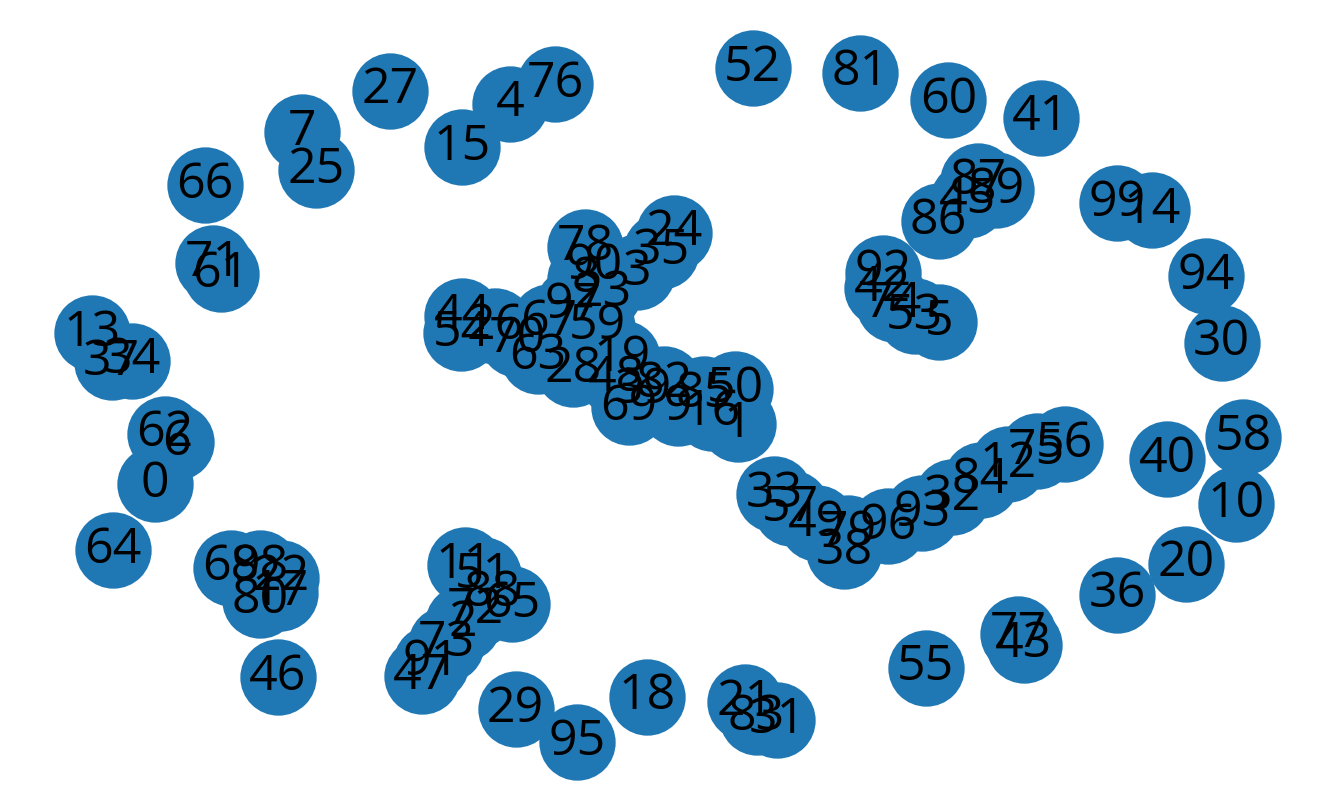

In [153]:
import networkx as nx
import matplotlib.pyplot as plt

# Number of nodes
n = 100

# Probability of creating an edge
p = 0.01

# Create an Erdős-Rényi graph
G = nx.erdos_renyi_graph(n, p)

nx.draw(G, with_labels=True)
plt.show()

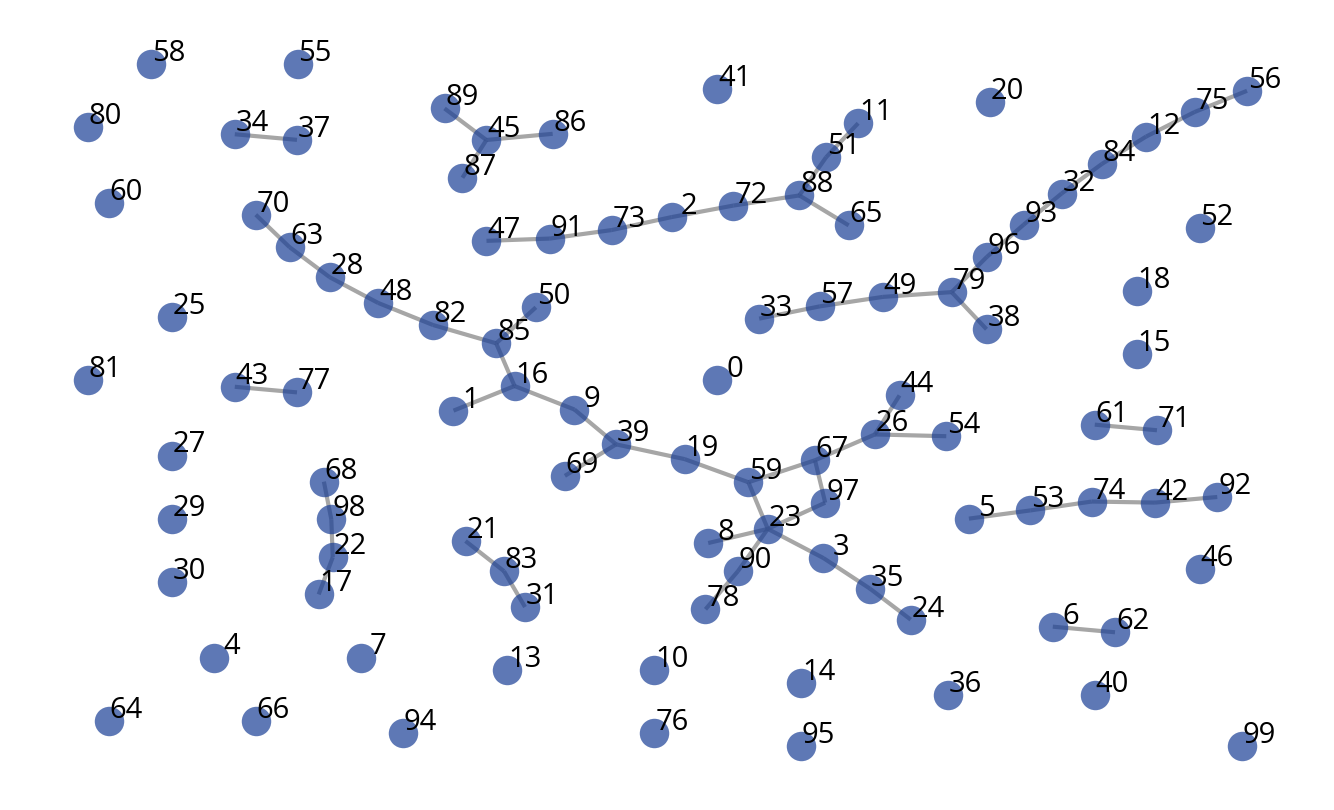

In [154]:
pos = nx.nx_agraph.graphviz_layout(G, prog='neato', args='-Gscale=.5')

nx.draw(G,
        pos,
        node_size=50,
        width=1,
        linewidths=0,
        alpha=.7, 
        edge_color='grey',
        node_color='#1a3f96',
        with_labels=False)

label_pos = {k: [v[0]+10, v[1]+10] for k, v in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=7)
plt.show()

In [ ]:
Z = PresAbs_DF_AsmSeqChk_Dict["Panaroo_Strict_MP"]

In [ ]:
Z.head(4)

In [ ]:
(Z[i_SampleIDs] == 0).sum().sum()

In [ ]:
(Z[i_SampleIDs] == 1).sum().sum()

In [ ]:
(Z[i_SampleIDs] == 2).sum().sum()

## PG Stats before and after PGQC Nucleotide Redundancy Analysis

In [ ]:
listOfRows = []

for i_Param, _ in PG_PresAbs_AsmGeneSeqChk_PATH_Dict.items():
    print(i_Param)

    if i_Param.startswith("SR_"):
        SeqType = "ShortRead"
    else:
        SeqType = "LongRead"

    if "Panaroo" in i_Param:
        PangenomeTool = "Panaroo"
    elif "Roary" in i_Param:
        PangenomeTool = "Roary"
    elif "Ppanggolin" in i_Param:
        PangenomeTool = "Ppanggolin"
    else:
        PangenomeTool = "Unknown"

    
    # OG
    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_DF_Dict[i_Param],
                                                      N_Genomes)

    i_row = (SeqType, PangenomeTool, i_Param, "Original", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)
    
    # Adjust w/ ASC + NSC (0.8)
    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param],
                                                      N_Genomes)

    i_row = (SeqType, PangenomeTool, i_Param, "AdjustByDNASeq_And_NSCluster08", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)
    
    print("-"*20, "\n")

PG_Summ_DF = pd.DataFrame(listOfRows)

PG_Summ_DF.columns = ["SeqType", "PangenomeTool", "Param", "Approach", "Total", "Core", "Accessory"]


In [ ]:
PG_Summ_DF.head(5)

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF = PG_Summ_DF[PG_Summ_DF["Approach"].isin(["Original", "AdjustBy_DNASeq", "AdjustByDNASeq_And_NSCluster08"])] 
PG_Summ_ASC_ASCwiNSC_DF["Approach"] = PG_Summ_ASC_ASCwiNSC_DF["Approach"].replace("AdjustBy_DNASeq", "PGQC - ASC")
PG_Summ_ASC_ASCwiNSC_DF["Approach"] = PG_Summ_ASC_ASCwiNSC_DF["Approach"].replace("AdjustByDNASeq_And_NSCluster08", "PGQC - ASC & NSC")

#PG_Summ_ASC_ASCwiNSC_DF['SeqType'] = np.where(PG_Summ_ASC_ASCwiNSC_DF['Param'].str.startswith('SR_'), 'SR Asm', 'Complete Asm')

PG_Summ_ASC_ASCwiNSC_DF["TypeAndTool"] = PG_Summ_ASC_ASCwiNSC_DF["SeqType"] + "-" + PG_Summ_ASC_ASCwiNSC_DF["PangenomeTool"]

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF.head(5)

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF["Approach"].value_counts()

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF.to_csv("./Data/PG_Summ_ASC_ASCwiNSC.tsv", sep = "\t", index=False)

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF.head(5)

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF["Accessory"].describe()

In [ ]:
#sns.set_context("poster", font_scale=1)
#sns.set_context("paper", font_scale=2)
sns.set_context("paper", font_scale=1.3)

OG_patch = mpatches.Patch(color="#3F84E5", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#E85D75", label='PGQC-NRC Adjusted Estimate')


fig, axs = plt.subplots(2, 1, figsize= (5, 8), sharex=True, sharey=False)

sns.boxplot(x = "SeqType", y = "Accessory", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[0], 
             palette = ["#417CC6", "#DA6376"],
            boxprops=dict(alpha=0.7), fliersize = 0)

sns.stripplot(x = "SeqType", y = "Accessory", hue = "Approach",
              data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[0],   
              alpha=1, dodge = True, jitter = True,
              palette = ["#417CC6", "#DA6376"],
              edgecolor='gray', linewidth=0, size = 8)

sns.boxplot(x = "SeqType", y = "Core", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[1], 
             palette = ["#417CC6", "#DA6376"],
            boxprops=dict(alpha=0.7), fliersize = 0)

sns.stripplot(x = "SeqType", y = "Core", hue = "Approach",
              data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[1],   
              alpha=1, dodge = True, jitter = True,
              palette = ["#417CC6", "#DA6376"],
              edgecolor='gray', linewidth=0, size = 8)

# Add a legend outside of the plot to the right

#axs[0].set_ylim(0, 1750)
axs[0].set_xlabel("")
axs[1].set_xlabel("")

#axs[0].legend(handles=[OG_patch, NRA_patch],
#              bbox_to_anchor=(1.35, 1), fontsize= 10) 
axs[0].get_legend().remove()
axs[1].get_legend().remove()

#axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()

plt.savefig("Results5_Plots/5.Mtb151CI.PG.BeforeAndAfter.NRCAdjust.Boxplot.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results5_Plots/5.Mtb151CI.PG.BeforeAndAfter.NRCAdjust.Boxplot.svg", bbox_inches="tight")

plt.show()

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF.shape

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF

In [ ]:
!mkdir ./Tables
PG_Summ_ASC_ASCwiNSC_DF.to_csv("./Tables/Mtb151.PG.SummStats.ASCwiNSC.tsv", sep = "\t", index = False)   

In [ ]:
# Isolate the original approach data as baseline
baseline = PG_Summ_ASC_ASCwiNSC_DF[PG_Summ_ASC_ASCwiNSC_DF['Approach'] == 'Original']

# Merge the baseline data with the full dataset to calculate the reduction percentage
comparison_df = PG_Summ_ASC_ASCwiNSC_DF.merge(baseline, on='Param', suffixes=('', '_Original'))


# Calculate the absolute change for Total, Core, and Accessory genes
comparison_df['Total_Change'] = comparison_df['Total'] - comparison_df['Total_Original']
comparison_df['Core_Change'] =  comparison_df['Core'] - comparison_df['Core_Original']
comparison_df['Accessory_Change'] = comparison_df['Accessory'] - comparison_df['Accessory_Original']

# Isolate the absolute changes
absolute_change_df = comparison_df[['Param', 'Approach', 'Total_Change', 'Core_Change', 'Accessory_Change']]

# Filter out the 'Original' approach since its change is zero by definition
absolute_change_df = absolute_change_df[absolute_change_df['Approach'] != 'Original']

absolute_change_df.reset_index(drop=True, inplace=True)

# Merging the absolute_change_df with the original dataframe PG_Summ_ASC_ASCwiNSC_DF
summary_absolute_change_df = PG_Summ_ASC_ASCwiNSC_DF.merge(absolute_change_df, on=['Param', 'Approach'], how='left')

# For the 'Original' approach, we should set the change to 0 as there is no change
summary_absolute_change_df['Total_Change'] = summary_absolute_change_df['Total_Change'].fillna(0)
summary_absolute_change_df['Core_Change'] = summary_absolute_change_df['Core_Change'].fillna(0)
summary_absolute_change_df['Accessory_Change'] = summary_absolute_change_df['Accessory_Change'].fillna(0)

summary_absolute_change_df.head()

In [ ]:
summary_absolute_change_df.query("Approach == 'PGQC - ASC & NSC' ")

In [ ]:
summary_absolute_change_df.shape

In [ ]:
# Isolate the original approach data as baseline
baseline = PG_Summ_ASC_ASCwiNSC_DF[PG_Summ_ASC_ASCwiNSC_DF['Approach'] == 'Original']

# Merge the baseline data with the full dataset to calculate the reduction percentage
comparison_df = PG_Summ_ASC_ASCwiNSC_DF.merge(baseline, on='Param', suffixes=('', '_Original'))

# Calculate the percent reduction for Total, Core, and Accessory genes
comparison_df['Total_Reduction'] = 100 * (1 - comparison_df['Total'] / comparison_df['Total_Original'])
comparison_df['Core_Reduction'] = 100 * (1 - comparison_df['Core'] / comparison_df['Core_Original'])
comparison_df['Accessory_Reduction'] = 100 * (1 - comparison_df['Accessory'] / comparison_df['Accessory_Original'])

# Isolate the percent reductions
percent_reduction_df = comparison_df[['Param', 'Approach', 'Total_Reduction', 'Core_Reduction', 'Accessory_Reduction']]

# Filter out the 'Original' approach since its reduction is zero by definition
percent_reduction_df = percent_reduction_df[percent_reduction_df['Approach'] != 'Original']

percent_reduction_df.reset_index(drop=True, inplace=True)

percent_reduction_df


In [ ]:
# # Merging the percent_reduction_df with the original dataframe PG_Summ_ASC_ASCwiNSC_DF
# summary_df = PG_Summ_ASC_ASCwiNSC_DF.merge(percent_reduction_df, on=['Param', 'Approach'], how='left')

# # For the 'Original' approach, we should set the reduction to 0% as there is no reduction
# summary_df['Total_Reduction'] = summary_df['Total_Reduction'].fillna(0)
# summary_df['Core_Reduction'] = summary_df['Core_Reduction'].fillna(0)
# summary_df['Accessory_Reduction'] = summary_df['Accessory_Reduction'].fillna(0)

# summary_df.head()

In [ ]:
#summary_df

In [ ]:
percent_reduction_df.query("Approach == 'PGQC - ASC & NSC'")[["Accessory_Reduction", "Core_Reduction"]].describe()

In [ ]:
summary_absolute_change_df.query("Approach == 'PGQC - ASC & NSC'")[["Accessory_Change", "Core_Change"]].describe()

In [ ]:
summary_absolute_change_df.query("Approach == 'PGQC - ASC & NSC'")[["Accessory_Change", "Core_Change", "Total_Change"]].describe()

In [ ]:

listOfRows = []
for i_param in list( PG_Summ_DF["Param"].unique() ):

    i_OG_Acc_Size = PG_Summ_DF.query(f"Param == '{i_param}' & Approach == 'Original' ")["Accessory"].values[0]   

    i_Adjust_Acc_Size = PG_Summ_DF.query(f"Param == '{i_param}' & Approach == 'AdjustByDNASeq_And_NSCluster08' ")["Accessory"].values[0]   

    Frac_Decrease = ((i_OG_Acc_Size - i_Adjust_Acc_Size) / i_OG_Acc_Size) * 100

    #print(i_param, i_OG_Acc_Size, i_Adjust_Acc_Size, round(Frac_Decrease, 2) )

    listOfRows.append( (i_param, i_OG_Acc_Size, i_Adjust_Acc_Size, round(Frac_Decrease, 2) ) )

FracReduce_Acc_DF = pd.DataFrame(listOfRows)

FracReduce_Acc_DF.columns = ["i_param", "i_OG_Acc_Size", "i_Adjust_Acc_Size", "Frac_Decrease"]
FracReduce_Acc_DF["Decrease_Acc_Size"] = FracReduce_Acc_DF["i_Adjust_Acc_Size"] -  FracReduce_Acc_DF["i_OG_Acc_Size"] 

FracReduce_Acc_DF


In [ ]:
FracReduce_Acc_DF["Frac_Decrease"].describe()

In [ ]:
listOfRows = []

for i_param in list( PG_Summ_DF["Param"].unique() ):

    i_OG_Acc_Size = PG_Summ_DF.query(f"Param == '{i_param}' & Approach == 'Original' ")["Total"].values[0]   

    i_Adjust_Acc_Size = PG_Summ_DF.query(f"Param == '{i_param}' & Approach == 'AdjustByDNASeq_And_NSCluster08' ")["Total"].values[0]   

    Frac_Decrease = ((i_OG_Acc_Size - i_Adjust_Acc_Size) / i_OG_Acc_Size) * 100

    listOfRows.append( (i_param, i_OG_Acc_Size, i_Adjust_Acc_Size, round(Frac_Decrease, 2) ) )

FracReduce_Total_DF = pd.DataFrame(listOfRows)

FracReduce_Total_DF.columns = ["i_param", "i_OG_Total_Size", "i_Adjust_Total_Size", "Frac_Decrease"]
FracReduce_Total_DF["Decrease_Total_Size"] = FracReduce_Total_DF["i_Adjust_Total_Size"] -  FracReduce_Total_DF["i_OG_Total_Size"] 

FracReduce_Total_DF

In [ ]:
FracReduce_Total_DF["Frac_Decrease"].mean()

In [ ]:
FracReduce_Total_DF["Frac_Decrease"].describe()

In [ ]:
PG_Summ_DF.head(1)

In [ ]:
PG_Summ_LR_DF = PG_Summ_DF[~PG_Summ_DF["Param"].str.contains("SR_") ]
PG_Summ_LR_DF.shape

In [ ]:
PG_Summ_SR_DF = PG_Summ_DF[PG_Summ_DF["Param"].str.contains("SR_") ]
PG_Summ_SR_DF.shape

In [ ]:
PG_Summ_DF.head(2)

## Measure # of genes merged during NSC step (0.8 thresh)

In [ ]:
listOfRows = []

for i_Param, i_Cluster_WiType_DF in ClusterStats_AsmSeqCheck_And_NSC08_Dict.items():

    print(i_Param, i_Cluster_WiType_DF["NS_ClusterID"].nunique(), i_Cluster_WiType_DF["GeneID"].nunique() ) #i_Cluster_WiType_DF["NumGenes"].sum() )

    N_NSCs = i_Cluster_WiType_DF["NS_ClusterID"].nunique()
    N_NSC_Genes = i_Cluster_WiType_DF["GeneID"].nunique() #i_Cluster_WiType_DF["NumGenes"].sum()

    listOfRows.append((i_Param, N_NSCs, N_NSC_Genes)  )

     
NSC08_Stats_DF = pd.DataFrame(listOfRows)

NSC08_Stats_DF.columns = ["Param", "Num_NSClusters", "N_Genes_InNSCs"]
NSC08_Stats_DF["GenesToClusters_Ratio"] = NSC08_Stats_DF["N_Genes_InNSCs"] / NSC08_Stats_DF["Num_NSClusters"]
NSC08_Stats_DF.shape



In [ ]:
i_Cluster_WiType_DF["GeneID"].nunique()

In [ ]:
250 - 111

In [ ]:
NSC08_Stats_DF

In [ ]:
i_Cluster_WiType_DF

In [ ]:
Z = ClusterStats_AsmSeqCheck_And_NSC08_Dict[i_Param]

In [ ]:
Z.head(4)

# Measure AsmSeqCheck Change Stats

### AsmSeqCheck Notes
- 0 means absent (CDS AA seq & DNA seq not found in ASM)
- 1 means CDS AA seq present in SR
- 2 Means abesnt but DNA Seq In Asm ("CDS Annotation Discrepancy")


In [ ]:
i_SampleIDs = SampleIDs_151CI_SOI

In [ ]:
listOfRows = []

for i_Param, i_PA_ASC_DF in PresAbs_DF_AsmSeqChk_Dict.items():
    
    #print(i_Param, i_PA_ASC_DF.shape)

    NAbs_0 = (i_PA_ASC_DF[i_SampleIDs] == 0).sum().sum()
    NPres_1 = (i_PA_ASC_DF[i_SampleIDs] == 1).sum().sum()
    NPres_InASC_2 = (i_PA_ASC_DF[i_SampleIDs] == 2).sum().sum()  
    listOfRows.append((i_Param, NAbs_0, NPres_1, NPres_InASC_2)  )
    
    # #print("\n\n\n")

   # break
     
ASC_Stats_DF = pd.DataFrame(listOfRows)

ASC_Stats_DF.columns = ["Param", "NAbs_0", "NPres_1", "NAbs_DNAInAsm_2"]
ASC_Stats_DF["NAbs_Total"] = ASC_Stats_DF["NAbs_0"] + ASC_Stats_DF["NAbs_DNAInAsm_2"]

ASC_Stats_DF["PercAbs_0"] = ASC_Stats_DF["NAbs_0"] / ASC_Stats_DF["NAbs_Total"] * 100
ASC_Stats_DF["PercAbs_2"] = ASC_Stats_DF["NAbs_DNAInAsm_2"] / ASC_Stats_DF["NAbs_Total"] * 100
ASC_Stats_DF["PercAbs_AnnoDiscrep"] = ASC_Stats_DF["PercAbs_2"]

ASC_Stats_DF.shape

In [ ]:
#(i_PA_ASC_DF[i_SampleIDs] == 0).sum().sum()

In [ ]:
#(i_PA_ASC_DF[i_SampleIDs] == 1).sum().sum()   

In [ ]:
#(i_PA_ASC_DF[i_SampleIDs] == 2).sum().sum()

In [ ]:
ASC_Stats_DF

In [ ]:
ASC_Stats_DF["PercAbs_AnnoDiscrep"].describe()

In [ ]:
i_PA_ASC_DF.shape

In [ ]:
sns.set_context("paper", font_scale=1.5)

fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# Add a legend outside of the plot to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()
plt.show()

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF.head(3)

In [ ]:
PG_Summ_ASC_ASCwiNSC_DF

In [ ]:
PG_Summ_BeforeAfter_DF = PG_Summ_ASC_ASCwiNSC_DF.query("Approach != 'PGQC - ASC' ")   

In [ ]:
PG_Summ_BeforeAfter_DF #.head(6)

# Generate barplots for PGQC-NRA analysis - Mtb151CI

In [ ]:
!mkdir Results5_Plots/

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
plt.style.use('./nqo.mplstyle')

In [ ]:
#sns.set_context("paper", font_scale=1.5)


orderToPlot_X = ['Panaroo_Strict_MP',
                 'Panaroo_Moderate_MP',
                 'Panaroo_Sens_MP',
                 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs_I80',
                 'Roary_NoSplitParalogs',
                 'SR_Panaroo_Strict_MP',
                 'SR_Panaroo_Moderate_MP',
                 'SR_Panaroo_Sens_MP',
                 'SR_Roary_NoSplitParalogs_I90',
                 'SR_Roary_NoSplitParalogs_I80',
                 'SR_Roary_NoSplitParalogs',]

Plot_TickLabels = ['Panaroo (Strict & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n Complete Assemblies',
                   'Roary (MergeParalogs & I90) \n Complete Assemblies',
                   'Roary (MergeParalogs & I80) \n Complete Assemblies',
                   'Roary (MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Strict & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n SR Assemblies',
                   'Roary (MergeParalogs & I90) \n SR Assemblies',
                   'Roary (MergeParalogs & I80) \n SR Assemblies',
                   'Roary (MergeParalogs) \n SR Assemblies', ]


fig, axs = plt.subplots(1, 2, figsize= (20, 13), sharex=False, sharey=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs[0], 
            order = orderToPlot_X, palette = ["#5E87CA", "#CA7481", "red", "purple"] )

axs[0].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})

sns.barplot(y = "Param", x = "Core", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs[1], 
            order = orderToPlot_X, palette = ["#5E87CA", "#CA7481", "red", "purple"] )

axs[1].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})



# Add a legend outside of the plot to the right
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs[0].set_xlabel("# of accessory genes", fontsize = 22)
axs[1].set_xlabel("# of core genes", fontsize = 22)

OG_patch = mpatches.Patch(color="#3F84E5", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#E85D75", label='PGQC-NRC Adjusted Estimate')

bbox_to_anchor=(1.75, 1)

axs[1].legend(handles=[OG_patch, NRA_patch],
              bbox_to_anchor=(1.75, 1), fontsize= 18) 

axs[0].get_legend().remove()

axs[0].tick_params(axis='x', labelsize=22)
axs[1].tick_params(axis='x', labelsize=22)

axs[0].set_ylabel("")
axs[1].set_ylabel("")

sns.despine()

plt.savefig("Results5_Plots/5.Mtb151.PG.GeneCounts.BeforeAndAfter.NRAAdjust.CombinedBarplot.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results5_Plots/5.Mtb151.PG.GeneCounts.BeforeAndAfter.NRAAdjust.CombinedBarplot.svg", bbox_inches="tight")

plt.show()

In [ ]:
#sns.set_context("paper", font_scale=1.5)


fig, axs = plt.subplots(1, 1, figsize= (20, 13), sharex=False, sharey=True)

sns.barplot(y = "Param", x = "Total", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs, 
            order = orderToPlot_X, palette = ["#9FB9DC", "#DBA6B2"] )


sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs, 
            order = orderToPlot_X, palette = ["#5E87CA", "#CA7481"] )

axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})


axs.set_xlabel("Number of genes (Accessory/Total)", fontsize = 22)

OG_patch = mpatches.Patch(color="#065275", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#bd342d", label='PGQC-NRC Adjusted Estimate')

axs.legend(handles=[OG_patch, NRA_patch],
              bbox_to_anchor=(1.35, 1), fontsize= 18) 

axs.tick_params(axis='x', labelsize=22)

axs.set_ylabel("")

sns.despine()

plt.savefig("Results5_Plots/5.Mtb151.PG.GeneCounts.BeforeAndAfter.NRAAdjust.OverlapBarplot.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results5_Plots/5.Mtb151.PG.GeneCounts.BeforeAndAfter.NRAAdjust.OverlapBarplot.svg", bbox_inches="tight")

plt.show()

In [ ]:
sns.set_context("paper", font_scale=1.5)

orderToPlot_X = ['Panaroo_Strict_MP',
                 'Panaroo_Moderate_MP',
                 'Panaroo_Sens_MP',
                 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs', #'Roary_Default', 
                 'SR_Panaroo_Strict_MP',
                 'SR_Panaroo_Moderate_MP',
                 'SR_Panaroo_Sens_MP',
                 'SR_Roary_NoSplitParalogs_I90',
                 'SR_Roary_NoSplitParalogs',] #'SR_Roary_Default', ]

Plot_TickLabels = ['Panaroo (Strict & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n Complete Assemblies',
                   'Roary (MergeParalogs & I90) \n Complete Assemblies',
                   'Roary (MergeParalogs) \n Complete Assemblies', #'Roary (Default) \n Complete Assemblies',
                   'Panaroo (Strict & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n SR Assemblies',
                   'Roary (MergeParalogs & I90) \n SR Assemblies',
                   'Roary (MergeParalogs) \n SR Assemblies', #'Roary (Default) \n SR Assemblies',
                  ]


fig, axs = plt.subplots(1, 2, figsize= (20, 13), sharex=False, sharey=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs[0], 
            order = orderToPlot_X, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

axs[0].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})

sns.barplot(y = "Param", x = "Core", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs[1], 
            order = orderToPlot_X, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

axs[1].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})



# Add a legend outside of the plot to the right
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs[0].set_xlabel("# of accessory genes", fontsize = 22)
axs[1].set_xlabel("# of core genes", fontsize = 22)

OG_patch = mpatches.Patch(color="#3F84E5", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#E85D75", label='PGQC-NRA Adjusted Estimate')

bbox_to_anchor=(1.75, 1)

axs[1].legend(handles=[OG_patch, NRA_patch],
              bbox_to_anchor=(1.75, 1), fontsize= 18) 

axs[0].get_legend().remove()

axs[0].tick_params(axis='x', labelsize=22)
axs[1].tick_params(axis='x', labelsize=22)

#axs[0].set_xlim()
axs[1].set_xlim(3000, 4000)

axs[0].set_ylabel("")
axs[1].set_ylabel("")

sns.despine()

#plt.savefig("Results5_Plots/5.Mtb151.PG.GeneCounts.BeforeAndAfter.NRAAdjust.CombinedBarplot.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results5_Plots/5.Mtb151.PG.GeneCounts.BeforeAndAfter.NRAAdjust.CombinedBarplot.svg", bbox_inches="tight")

plt.show()

In [ ]:
PG_Summ_BeforeAfter_DF

In [ ]:
FracReduce_Acc_DF

In [ ]:
summary_absolute_change_df

In [ ]:
summary_absolute_change_df.query("Approach == 'PGQC - ASC & NSC' ")

In [ ]:
percent_reduction_df.query("Approach == 'PGQC - ASC & NSC' ")

In [ ]:
NSC08_Stats_DF

In [ ]:
summary_absolute_change_df.query("Approach == 'PGQC - ASC & NSC' ")

In [ ]:
ASC_Stats_DF

In [116]:
STOP!

SyntaxError: invalid syntax (<ipython-input-116-3bfd59f24194>, line 1)

In [ ]:
# sns.set_context("paper", font_scale=1.5)

# fig, axs = plt.subplots(1, 1, figsize= (8, 10), sharex=True)

# sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
#             data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# # Add a legend outside of the plot to the right
# #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# axs.set_xlabel("# of accessory genes", fontsize = 20)
# plt.ylabel("")
# sns.despine()
# plt.show()

In [ ]:
# sns.set_context("paper", font_scale=1.5)

# orderToPlot_X = ['Panaroo_Strict_MP',
#                  'Panaroo_Moderate_MP',
#                  'Panaroo_Sens_MP',
#                  'Roary_NoSplitParalogs_I90',
#                  'Roary_NoSplitParalogs_I80',
#                  'Roary_NoSplitParalogs',
#                  'SR_Panaroo_Strict_MP',
#                  'SR_Panaroo_Moderate_MP',
#                  'SR_Panaroo_Sens_MP',
#                  'SR_Roary_NoSplitParalogs_I90',
#                  'SR_Roary_NoSplitParalogs_I80',
#                  'SR_Roary_NoSplitParalogs',]

# Plot_TickLabels = ['Panaroo (Strict & MergeParalogs) \n Complete Assemblies',
#                    'Panaroo (Moderate & MergeParalogs) \n Complete Assemblies',
#                    'Panaroo (Sensitive & MergeParalogs) \n Complete Assemblies',
#                    'Roary (MergeParalogs & I90) \n Complete Assemblies',
#                    'Roary (MergeParalogs & I80) \n Complete Assemblies',
#                    'Roary (MergeParalogs) \n Complete Assemblies',
#                    'Panaroo (Strict & MergeParalogs) \n SR Assemblies',
#                    'Panaroo (Moderate & MergeParalogs) \n SR Assemblies',
#                    'Panaroo (Sensitive & MergeParalogs) \n SR Assemblies',
#                    'Roary (MergeParalogs & I90) \n SR Assemblies',
#                    'Roary (MergeParalogs & I80) \n SR Assemblies',
#                    'Roary (MergeParalogs) \n SR Assemblies', ]


# fig, axs = plt.subplots(1, 1, figsize= (10, 13), sharex=True)

# sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
#             data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, 
#             order = orderToPlot_X, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})


# # Add a legend outside of the plot to the right
# #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# axs.set_xlabel("# of accessory genes", fontsize = 15)
# plt.ylabel("")
# sns.despine()
# plt.show() 

In [ ]:
# sns.set_context("paper", font_scale=1.5)

# fig, axs = plt.subplots(1, 1, figsize= (10, 13), sharex=True)

# sns.barplot(y = "Param", x = "Core", hue = "Approach",
#             data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, 
#             order = orderToPlot_X, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})


# # Add a legend outside of the plot to the right
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# axs.set_xlabel("# of accessory genes", fontsize = 15)
# plt.ylabel("")
# sns.despine()
# plt.show() 

In [ ]:
# sns.set_context("paper", font_scale=1.5)

# fig, axs = plt.subplots(1, 1, figsize= (8, 10), sharex=True)

# sns.barplot(y = "Param", x = "Core", hue = "Approach",
#             data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# # Add a legend outside of the plot to the right
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# axs.set_xlabel("# of core genes", fontsize = 20)
# plt.ylabel("")
# sns.despine()
# plt.show()

# Presence Absence Matrix Visualization

# Test - Explore code for Viz of PA matrices (Wi PGQC)

In [ ]:
from matplotlib.colors import ListedColormap

colormap_dict = {0: "#FFFFD6", 1: "#041B4C", 2: "black", 3: "red", 4: "#15ACBB", 5: "#15ACBB"}

# Convert the custom dictionary to a colormap
colors = [colormap_dict[i] for i in sorted(colormap_dict.keys())]
custom_cmap = ListedColormap(colors)


#colormap_dict2 = {0: "#FFFFD6", 1: "#041B4C", 2: "#FFFFD6", 3: "#FFFFD6", 4: "#FFFFD6", 5: "#FFFFD6"}

# Convert the custom dictionary to a colormap
#colors_2 = [colormap_dict2[i] for i in sorted(colormap_dict2.keys())]
#custom_cmap_2 = ListedColormap(colors_2)


colormap_dict_PGQC_3 = {0: "#FFFFD6", 1: "#041B4C", 2: "#15ACBB", }

# Convert the custom dictionary to a colormap
colors_PGQC_3 = [colormap_dict_PGQC_3[i] for i in sorted(colormap_dict_PGQC_3.keys())]
custom_cmap_PGQC_3 = ListedColormap(colors_PGQC_3)


### Test viz w/ Panaroo - Mod MP - LR

In [ ]:
PresAbs_DF_AsmSeqChk_Dict.keys()

In [ ]:
PresAbs_DF_AsmSeqChk_Dict["Panaroo_Moderate_MP"].head(2)

#### Set param of interest

In [ ]:
i_Param = "Panaroo_Moderate_MP"


In [ ]:
i_PA_DF = PresAbs_DF_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)

i_PA_ASC_DF = PresAbs_DF_AsmSeqChk_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)

i_PA_ASC_NSC08_DF = PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)



In [ ]:
get_PG_Stats_FromPresAbs(i_PA_DF, N_Genomes)


In [ ]:
get_PG_Stats_FromDNASeqPresAbs(i_PA_ASC_DF, N_Genomes)


In [ ]:
get_PG_Stats_FromPresAbs(i_PA_ASC_NSC08_DF, N_Genomes)


In [ ]:
i_PA_ASC_NSC08_DF.head(4)

### A) Plot PresAbs (OG) - Panaroo Mod + MP

#### Plot entire PG

In [ ]:
DF = i_PA_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

#### Plot Acc Genes

In [ ]:
DF = i_PA_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

get_PG_Stats_FromPresAbs(i_PA_DF, N_Genomes)

### B) Plot PresAbs (ASC Adjusted) - Panaroo Mod + MP

In [ ]:
i_PA_ASC_DF.head(1)

In [ ]:
DF = i_PA_ASC_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

get_PG_Stats_FromDNASeqPresAbs(DF, N_Genomes)


In [ ]:
DF = i_PA_ASC_DF.sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')


plt.show() 
get_PG_Stats_FromDNASeqPresAbs(DF, N_Genomes)


### C) Plot PresAbs (ASC & NSC Adjusted) - Panaroo Mod + MP

In [ ]:
DF = i_PA_ASC_NSC08_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 
get_PG_Stats_FromPresAbs(DF, N_Genomes)
#DF.query("NumAsm_WiGene < 10").shape

In [ ]:
heatmap_data.shape

### C) Plot PresAbs (ASC & NSC 0.8 Adjusted) - Panaroo Mod + MP

In [ ]:
DF = i_PA_ASC_NSC08_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 
get_PG_Stats_FromPresAbs(DF, N_Genomes)

#DF.query("NumAsm_WiGene < 10").shape

In [ ]:
DF = i_PA_ASC_NSC08_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 15")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 
get_PG_Stats_FromPresAbs(DF, N_Genomes)

DF.query("NumAsm_WiGene < 10").shape

In [ ]:
#DF.query("NumAsm_WiGene < 10")[OrderOfSampleIDs_Phylo + ["NumAsm_WiGene"]]

In [ ]:
get_PG_Stats_FromPresAbs(DF, N_Genomes, True)

## Plot all BEFORE & AFTER PGQC ASC & NSC Adjustment - PA plots

In [ ]:
for i_Param in list(PresAbs_DF_AsmSeqChk_Dict.keys()): #['SR_Panaroo_Strict',  'SR_Roary_Default',]: 
                #'SR_Panaroo_Moderate', 'SR_Panaroo_Sens', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90']:

    print(i_Param)

    DF = PresAbs_DF_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)
    
    heatmap_data = DF.query("NumAsm_WiGene < 158")[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_PGQC_3, vmax= 3,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    # Plotting the heatmap - AFTER SR AND LR Asm QC

    DF = PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param].query("NumAsm_WiGene < 158").sort_values("NumAsm_WiGene", ascending=False)
    
    heatmap_data = DF.query("NumAsm_WiGene <= 158")[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_PGQC_3, vmax= 3,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    #break 



## Plot all BEFORE & AFTER PGQC ASC & NSC Adjustment - PA plots

In [ ]:
for i_Param in list(PresAbs_DF_AsmSeqChk_Dict.keys()): #['SR_Panaroo_Strict',  'SR_Roary_Default',]: 
                #'SR_Panaroo_Moderate', 'SR_Panaroo_Sens', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90']:

    print(i_Param)

    DF = PresAbs_DF_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)
    
    heatmap_data = DF[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_PGQC_3, vmax= 3,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    # Plotting the heatmap - AFTER SR AND LR Asm QC

    DF = PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)
    
    heatmap_data = DF.query("NumAsm_WiGene <= 158")[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_PGQC_3, vmax= 3,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    break 

